In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

 99% 1.61G/1.62G [00:12<00:00, 164MB/s]
100% 1.62G/1.62G [00:12<00:00, 137MB/s]


In [ ]:
!unzip ocular-disease-recognition-odir5k.zip -d img

In [ ]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os

# Preparation

###Prepare dataset

In [ ]:
df = pd.read_csv("img/full_df.csv")
df.head(3)

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg

In [ ]:
def has_disease(text, disease, without=""):
    if disease in text and without not in text:
        return 1
    else:
        return 0

In [ ]:
df["left_C"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_disease(x, "cataract"))
df["right_C"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_disease(x, "cataract"))

df["left_G"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_disease(x, "glaucoma"))
df["right_G"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_disease(x, "glaucoma"))

df["left_A"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_disease(x, "age-related macular degeneration"))
df["right_A"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_disease(x, "age-related macular degeneration"))

df["left_H"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_disease(x, "hypertensive"))
df["right_H"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_disease(x, "hypertensive"))

df["left_M"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_disease(x, "myopi"))
df["right_M"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_disease(x, "myopi"))

df["left_D"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_disease(x, "retinopathy", "hypertensive"))
df["right_D"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_disease(x, "retinopathy", "hypertensive"))

In [ ]:
def get_disease_dataset(disease):
  left = df.loc[(df[disease] ==1) & (df["left_"+disease] == 1)]["Left-Fundus"].values
  right = df.loc[(df[disease] ==1) & (df["right_"+disease] == 1)]["Right-Fundus"].values
  return np.concatenate((left,right),axis=0)

In [ ]:
def get_normal_dataset(size, disease):
  left = df.loc[(df[disease] ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(int(size/2),random_state=42).values
  right = df.loc[(df[disease] ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(int(size/2),random_state=42).values
  return np.concatenate((left,right),axis=0)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "img/preprocessed_images/"
image_size=224
def create_dataset(dataset,image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue

        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset


In [ ]:
def preview_dataset(dataset, disease):
  plt.figure(figsize=(12,7))
  for i in range(10):
      sample = random.choice(range(len(dataset)))
      image = dataset[sample][0]
      category = dataset[sample][1]
      if category== 0:
          label = "Normal"
      else:
          label = disease
      plt.subplot(2,5,i+1)
      plt.imshow(image)
      plt.xlabel(label)
  plt.tight_layout()

0it [00:00, ?it/s]
100%|██████████| 590/590 [00:03<00:00, 173.89it/s]


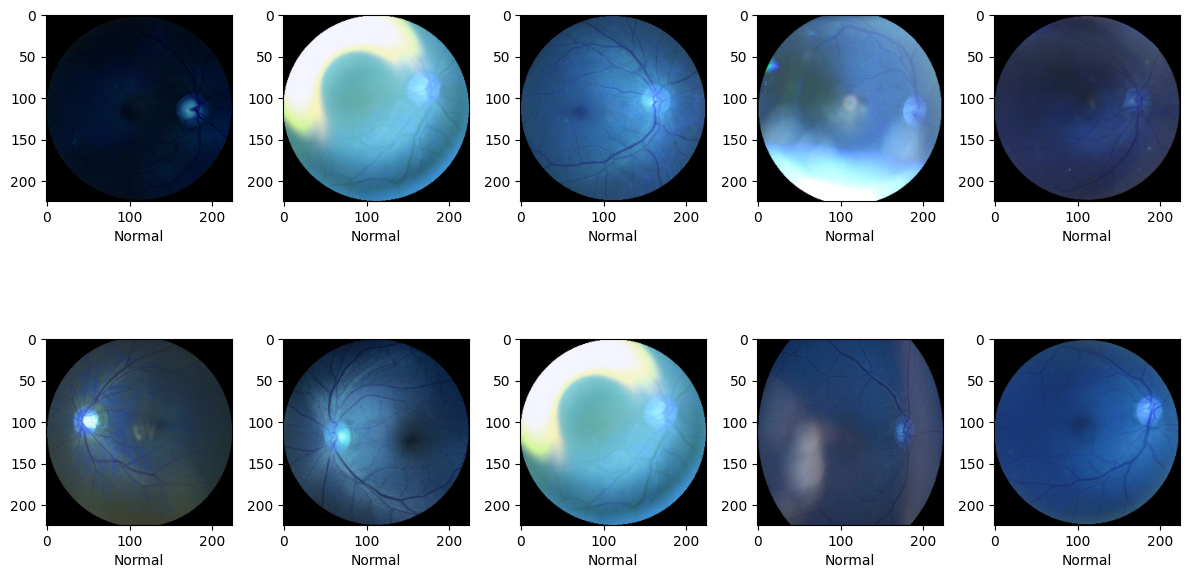

In [ ]:
cataract = get_disease_dataset("C")
c_normal = get_normal_dataset(590, "C")
c_dataset = create_dataset([], cataract,1)
c_dataset = create_dataset(c_dataset, c_normal,0)
preview_dataset(c_dataset, "Cataract")

0it [00:00, ?it/s]
100%|██████████| 600/600 [00:04<00:00, 143.85it/s]


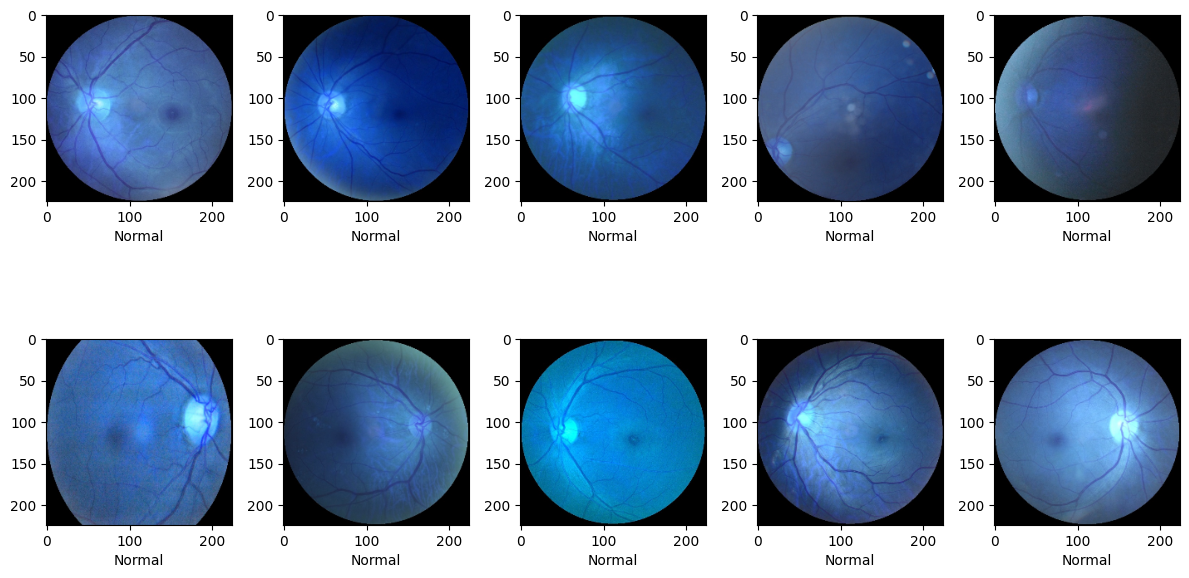

In [ ]:
glaucoma = get_disease_dataset("G")
g_normal = get_normal_dataset(600, "G")
g_dataset = create_dataset([], glaucoma,1)
g_dataset = create_dataset(g_dataset, g_normal,0)
preview_dataset(g_dataset, "Glaucoma")

0it [00:00, ?it/s]
100%|██████████| 550/550 [00:02<00:00, 223.73it/s]


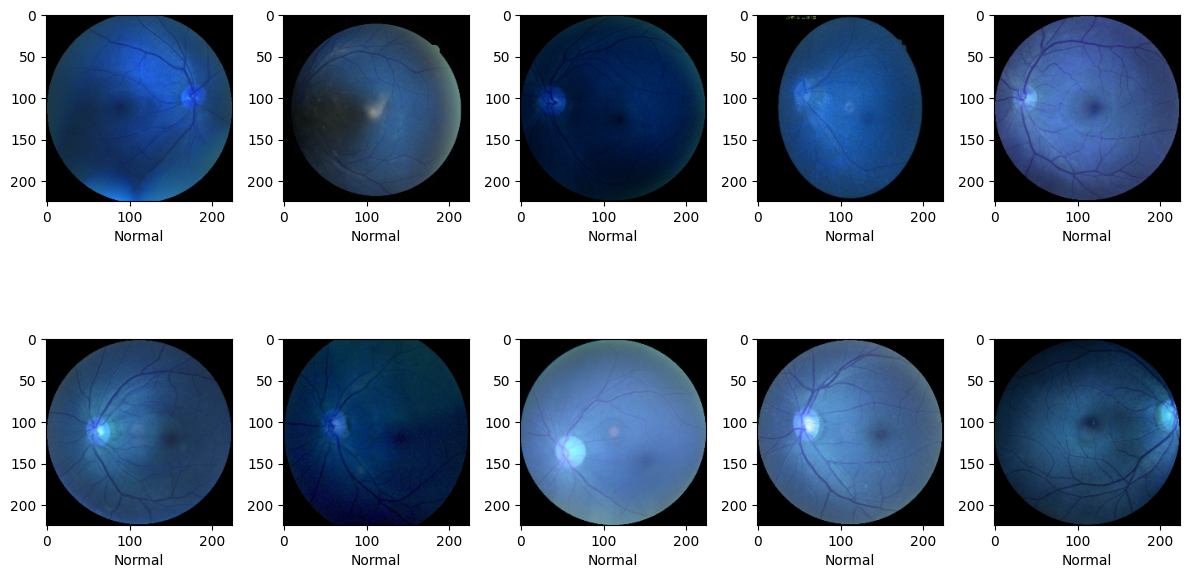

In [ ]:
armd = get_disease_dataset("A")
armd_normal = get_normal_dataset(550, "A")
armd_dataset = create_dataset([], armd,1)
armd_dataset = create_dataset(armd_dataset, armd_normal,0)
preview_dataset(armd_dataset, "ARMD")

0it [00:00, ?it/s]
100%|██████████| 350/350 [00:01<00:00, 234.18it/s]


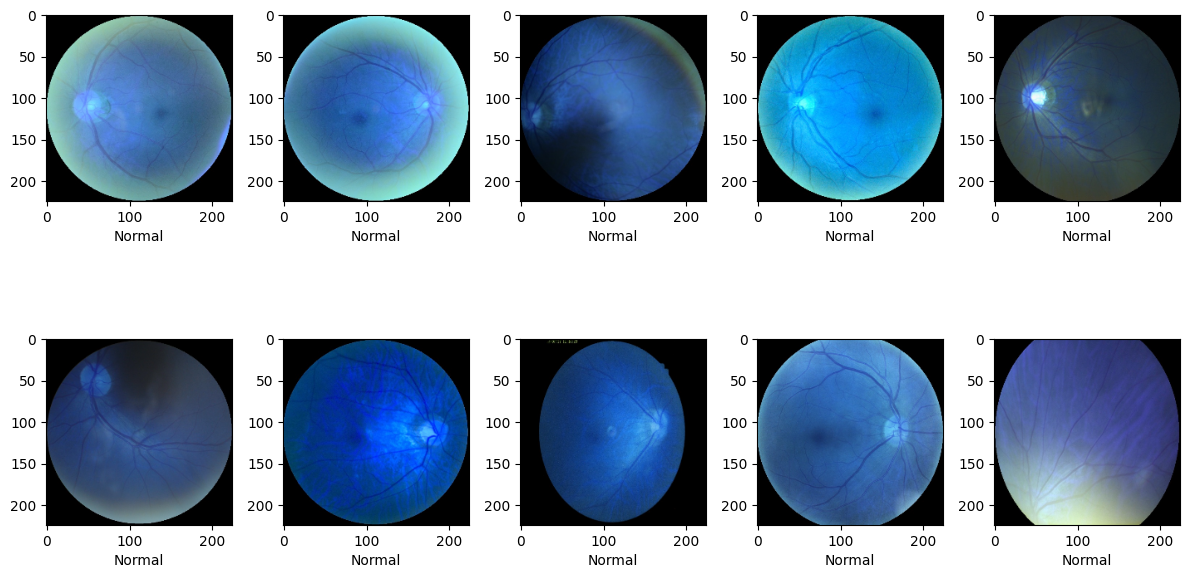

In [ ]:
hypertension = get_disease_dataset("H")
h_normal = get_normal_dataset(350, "H")
h_dataset = create_dataset([], hypertension,1)
h_dataset = create_dataset(h_dataset, h_normal,0)
preview_dataset(h_dataset, "Hypertension")

0it [00:00, ?it/s]
100%|██████████| 450/450 [00:02<00:00, 203.90it/s]


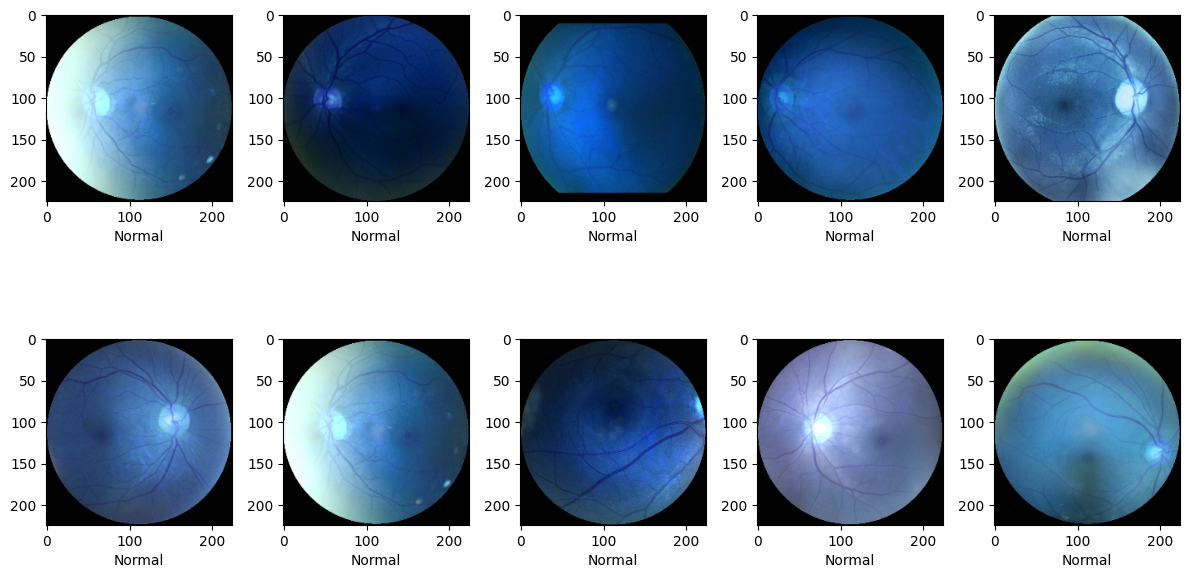

In [ ]:
myopia = get_disease_dataset("M")
m_normal = get_normal_dataset(450, "M")
m_dataset = create_dataset([], myopia,1)
m_dataset = create_dataset(m_dataset, m_normal,0)
preview_dataset(m_dataset, "Myopia")

100%|██████████| 3200/3200 [00:15<00:00, 212.98it/s]


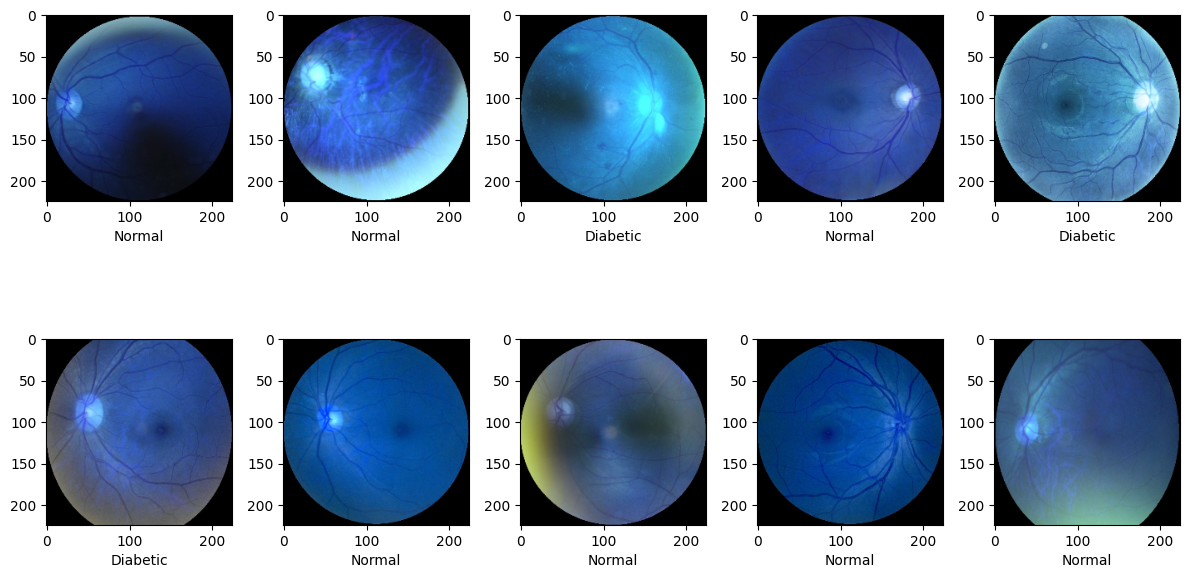

In [ ]:
diabetic = get_disease_dataset("D")
d_normal = get_normal_dataset(3200, "D")
d_dataset = create_dataset([], diabetic,1)
d_dataset = create_dataset(d_dataset, d_normal,0)
preview_dataset(d_dataset, "Diabetic")

## Prepare results

In [ ]:
def get_loss_and_accuracy(model, x_test,y_test):
  return model.evaluate(x_test,y_test)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
def predict(model, x_test):
  return (model.predict(x_test) > 0.5).astype("int32")

In [ ]:
def save_model(model, name):
  model.save(name+".h5")

In [ ]:
def get_accuracy_score(y_test,y_pred):
  return accuracy_score(y_test,y_pred)

In [ ]:
def get_classification_report(y_test,y_pred):
  return classification_report(y_test,y_pred)

In [ ]:
from sklearn import metrics
import sklearn.metrics
def plot_conf_matrix(y_test, vgg_19_y_pred, vgg_16_y_pred, en_b5_y_pred, en_b7_y_pred, disease):
  cm_vgg_19 = metrics.confusion_matrix(y_test,vgg_19_y_pred)
  cm_vgg_16 = metrics.confusion_matrix(y_test,vgg_16_y_pred)
  cm_en_b5 = metrics.confusion_matrix(y_test,en_b5_y_pred)
  cm_en_b7 = metrics.confusion_matrix(y_test,en_b7_y_pred)
  fig, ax = plt.subplots(2, 2, figsize=(10,10))
  ax[0, 0].title.set_text("VGG 19")
  metrics.ConfusionMatrixDisplay(confusion_matrix=cm_vgg_19, display_labels=["normal",disease]).plot(ax=ax[0,0], colorbar=False, cmap='Blues')
  ax[0, 1].title.set_text("VGG 16")
  metrics.ConfusionMatrixDisplay(confusion_matrix=cm_vgg_16, display_labels=["normal",disease]).plot(ax=ax[0,1], colorbar=False, cmap='Blues')
  ax[1,0].title.set_text("EN B5")
  metrics.ConfusionMatrixDisplay(confusion_matrix=cm_en_b5, display_labels=["normal",disease]).plot(ax=ax[1,0], colorbar=False, cmap='Blues')
  ax[1,1].title.set_text("EN B7")
  metrics.ConfusionMatrixDisplay(confusion_matrix=cm_en_b7, display_labels=["normal",disease]).plot(ax=ax[1,1], colorbar=False, cmap='Blues')

In [ ]:
def plot_accuracy_and_loss(vgg_19_history, vgg_16_history, en_b5_history, en_b7_history):
  plt.style.use("ggplot")
  fig, ax = plt.subplots(2, 4, figsize=(18,12))
  epochs = range(1,16)
  ax[0, 0].plot(epochs,vgg_19_history.history["accuracy"],"go-")
  ax[0, 0].plot(epochs,vgg_19_history.history["val_accuracy"],"ro-")
  ax[0, 0].title.set_text("VGG 19 Accuracy")
  ax[0, 0].set_xlabel("Epochs")
  ax[0, 0].set_ylabel("Accuracy")
  ax[0, 0].legend(["Train","val"],loc = "upper left")

  ax[0, 1].plot(epochs,vgg_16_history.history["accuracy"],"go-")
  ax[0, 1].plot(epochs,vgg_16_history.history["val_accuracy"],"ro-")
  ax[0, 1].title.set_text("VGG 16 Accuracy")
  ax[0, 1].set_xlabel("Epochs")
  ax[0, 1].set_ylabel("Accuracy")
  ax[0, 1].legend(["Train","val"],loc = "upper left")

  ax[0, 2].plot(epochs,en_b5_history.history["accuracy"],"go-")
  ax[0, 2].plot(epochs,en_b5_history.history["val_accuracy"],"ro-")
  ax[0, 2].title.set_text("EfficientNet B5 Accuracy")
  ax[0, 2].set_xlabel("Epochs")
  ax[0, 2].set_ylabel("Accuracy")
  ax[0, 2].legend(["Train","val"],loc = "upper left")

  ax[0, 3].plot(epochs,en_b7_history.history["accuracy"],"go-")
  ax[0, 3].plot(epochs,en_b7_history.history["val_accuracy"],"ro-")
  ax[0, 3].title.set_text("EfficientNet B7 Accuracy")
  ax[0, 3].set_xlabel("Epochs")
  ax[0, 3].set_ylabel("Accuracy")
  ax[0, 3].legend(["Train","val"],loc = "upper left")

  ax[1, 0].plot(epochs,vgg_19_history.history["loss"],"go-")
  ax[1, 0].plot(epochs,vgg_19_history.history["val_loss"],"ro-")
  ax[1, 0].title.set_text("VGG 19 Loss")
  ax[1, 0].set_xlabel("Epochs")
  ax[1, 0].set_ylabel("Loss")
  ax[1, 0].legend(["Train","val"],loc = "upper left")

  ax[1, 1].plot(epochs,vgg_16_history.history["loss"],"go-")
  ax[1, 1].plot(epochs,vgg_16_history.history["val_loss"],"ro-")
  ax[1, 1].title.set_text("VGG 16 Loss")
  ax[1, 1].set_xlabel("Epochs")
  ax[1, 1].set_ylabel("Loss")
  ax[1, 1].legend(["Train","val"],loc = "upper left")

  ax[1, 2].plot(epochs,en_b5_history.history["loss"],"go-")
  ax[1, 2].plot(epochs,en_b5_history.history["val_loss"],"ro-")
  ax[1, 2].title.set_text("EfficientNet B5 Loss")
  ax[1, 2].set_xlabel("Epochs")
  ax[1, 2].set_ylabel("Loss")
  ax[1, 2].legend(["Train","val"],loc = "upper left")

  ax[1, 3].plot(epochs,en_b7_history.history["loss"],"go-")
  ax[1, 3].plot(epochs,en_b7_history.history["val_loss"],"ro-")
  ax[1, 3].title.set_text("EfficientNet B7 Loss")
  ax[1, 3].set_xlabel("Epochs")
  ax[1, 3].set_ylabel("Loss")
  ax[1, 3].legend(["Train","val"],loc = "upper left")

  plt.show()

In [ ]:
def plot_actual_prediction(x_test, y_test, y_pred, disease):
  plt.figure(figsize=(12,7))
  for i in range(10):
      sample = random.choice(range(len(x_test)))
      image = x_test[sample]
      category = y_test[sample]
      pred_category = y_pred[sample]

      if category== 0:
          label = "Normal"
      else:
          label = disease
      if pred_category== 0:
          pred_label = "Normal"
      else:
          pred_label = disease
      plt.subplot(2,5,i+1)
      plt.imshow(image)
      plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
  plt.tight_layout()

## Prepare functions

In [ ]:
from sklearn.model_selection import train_test_split
def get_train_val_test_data(dataset, train_size):
  x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
  y = np.array([i[1] for i in dataset])
  x_train,x_temp,y_train,y_temp = train_test_split(x,y,train_size=train_size)
  x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5)
  return x_train, x_test, x_val, y_val, y_train, y_test

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
def init_vgg_19_model():
  vgg_19 = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))
  for layer in vgg_19.layers:
    layer.trainable = False
  return vgg_19

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
def init_vgg_16_model():
  vgg_16 = VGG16(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))
  for layer in vgg_16.layers:
    layer.trainable = False
  return vgg_16

In [ ]:
from tensorflow.keras.applications import EfficientNetB5
def init_en_b5_model():
  efficient_net_b5 = EfficientNetB5(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))
  for layer in efficient_net_b5.layers:
    layer.trainable = False
  return efficient_net_b5

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
def init_en_b7_model():
  efficient_net_b7 = EfficientNetB7(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))
  for layer in efficient_net_b7.layers:
    layer.trainable = False
  return efficient_net_b7

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
def init_model(pretained):
  model = Sequential()
  model.add(pretained)
  model.add(Flatten())
  model.add(Dense(1,activation="sigmoid"))
  model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
  return model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
def get_callbacks(model_name):
  checkpoint = ModelCheckpoint(model_name+".h5",monitor="val_acc",verbose=1,save_best_only=True,
                              save_weights_only=False,period=1)
  earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)
  return [checkpoint, earlystop]

In [ ]:
def train_model(model, x_train, y_train, x_test, y_test, callbacks):
  history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=callbacks)
  return history

# Results

### Glaucoma

In [ ]:
g_x_train,g_x_test,g_x_val, g_y_val,g_y_train,g_y_test=get_train_val_test_data(g_dataset, 0.7)
print(len(g_x_train),len(g_x_test),len(g_x_val), len(g_y_val),len(g_y_train),len(g_y_test))

849 182 182 182 849 182


In [ ]:
g_vgg_19=init_vgg_19_model()
g_vgg_16=init_vgg_16_model()
g_en_b5=init_en_b5_model()
g_en_b7=init_en_b7_model()

258076736/258076736 [==============================] - 1s 0us/step


In [ ]:
g_vgg_19_model = init_model(g_vgg_19)
g_vgg_16_model = init_model(g_vgg_16)
g_en_b5_model = init_model(g_en_b5)
g_en_b7_model = init_model(g_en_b7)

In [ ]:
g_vgg_19_callbacks=get_callbacks("glaucoma_vgg19")
g_vgg_16_callbacks=get_callbacks("glaucoma_vgg16")
g_en_b5_callbacks=get_callbacks("glaucoma_efficient_net_b5")
g_en_b7_callbacks=get_callbacks("glaucoma_efficient_net_b7")

In [ ]:
g_vgg_19_history=train_model(g_vgg_19_model, g_x_train, g_y_train, g_x_val, g_y_val, g_vgg_19_callbacks)

Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 3.1780 - accuracy: 0.6690

27/27 [==============================] - 23s 424ms/step - loss: 3.1780 - accuracy: 0.6690 - val_loss: 1.7162 - val_accuracy: 0.7747
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.8622

27/27 [==============================] - 5s 170ms/step - loss: 0.7312 - accuracy: 0.8622 - val_loss: 1.0084 - val_accuracy: 0.8187
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9529

27/27 [==============================] - 5s 190ms/step - loss: 0.1596 - accuracy: 0.9529 - val_loss: 0.7300 - val_accuracy: 0.8571
Epoch 4/15
27/27 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9870

27/27 [==============================] - 5s 188ms/step - loss: 0.0368 - accuracy: 0.9870 - val_loss: 0.6991 - val_accuracy: 0.8571
Epoch 5/15
27/27 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9929

27/27 [==============================] - 5s 189ms/step - loss: 0.0245 - accuracy: 0.9929 - val_loss: 0.7614 - val_accuracy: 0.8407
Epoch 6/15
27/27 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9965

27/27 [==============================] - 5s 193ms/step - loss: 0.0133 - accuracy: 0.9965 - val_loss: 0.6374 - val_accuracy: 0.8626
Epoch 7/15
27/27 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

27/27 [==============================] - 5s 191ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.7025 - val_accuracy: 0.8791
Epoch 8/15
27/27 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

27/27 [==============================] - 5s 176ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.6782 - val_accuracy: 0.8626
Epoch 9/15
27/27 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

27/27 [==============================] - 5s 178ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.6690 - val_accuracy: 0.8681
Epoch 10/15
27/27 [==============================] - ETA: 0s - loss: 8.7136e-04 - accuracy: 1.0000

27/27 [==============================] - 5s 192ms/step - loss: 8.7136e-04 - accuracy: 1.0000 - val_loss: 0.6651 - val_accuracy: 0.8736
Epoch 11/15
27/27 [==============================] - ETA: 0s - loss: 7.7918e-04 - accuracy: 1.0000

27/27 [==============================] - 5s 179ms/step - loss: 7.7918e-04 - accuracy: 1.0000 - val_loss: 0.6646 - val_accuracy: 0.8736
Epoch 12/15
27/27 [==============================] - ETA: 0s - loss: 7.0316e-04 - accuracy: 1.0000

27/27 [==============================] - 5s 181ms/step - loss: 7.0316e-04 - accuracy: 1.0000 - val_loss: 0.6620 - val_accuracy: 0.8736
Epoch 13/15
27/27 [==============================] - ETA: 0s - loss: 6.5162e-04 - accuracy: 1.0000

27/27 [==============================] - 5s 197ms/step - loss: 6.5162e-04 - accuracy: 1.0000 - val_loss: 0.6620 - val_accuracy: 0.8736
Epoch 14/15
27/27 [==============================] - ETA: 0s - loss: 6.0604e-04 - accuracy: 1.0000

27/27 [==============================] - 5s 199ms/step - loss: 6.0604e-04 - accuracy: 1.0000 - val_loss: 0.6594 - val_accuracy: 0.8736
Epoch 15/15
27/27 [==============================] - ETA: 0s - loss: 5.7164e-04 - accuracy: 1.0000

27/27 [==============================] - 5s 198ms/step - loss: 5.7164e-04 - accuracy: 1.0000 - val_loss: 0.6596 - val_accuracy: 0.8736


In [ ]:
g_vgg_16_history=train_model(g_vgg_16_model, g_x_train, g_y_train, g_x_val, g_y_val, g_vgg_16_callbacks)

Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 2.8115 - accuracy: 0.6820

27/27 [==============================] - 6s 184ms/step - loss: 2.8115 - accuracy: 0.6820 - val_loss: 1.4986 - val_accuracy: 0.7747
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.8893

27/27 [==============================] - 4s 155ms/step - loss: 0.4724 - accuracy: 0.8893 - val_loss: 0.6868 - val_accuracy: 0.8516
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9588

27/27 [==============================] - 4s 155ms/step - loss: 0.0988 - accuracy: 0.9588 - val_loss: 0.7377 - val_accuracy: 0.8681
Epoch 4/15
27/27 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 0.9906

27/27 [==============================] - 4s 157ms/step - loss: 0.0234 - accuracy: 0.9906 - val_loss: 0.6929 - val_accuracy: 0.8516
Epoch 5/15
27/27 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000

27/27 [==============================] - 5s 179ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.7298 - val_accuracy: 0.8901
Epoch 6/15
27/27 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

27/27 [==============================] - 5s 180ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.7392 - val_accuracy: 0.8956
Epoch 7/15
27/27 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

27/27 [==============================] - 5s 181ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.6973 - val_accuracy: 0.8791
Epoch 8/15
27/27 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

27/27 [==============================] - 4s 163ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.7083 - val_accuracy: 0.8901
Epoch 9/15
27/27 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

27/27 [==============================] - 5s 184ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7230 - val_accuracy: 0.8901
Epoch 10/15
27/27 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

27/27 [==============================] - 5s 184ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.7087 - val_accuracy: 0.8956
Epoch 11/15
27/27 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

27/27 [==============================] - 5s 182ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.7106 - val_accuracy: 0.8956
Epoch 12/15
27/27 [==============================] - ETA: 0s - loss: 9.7817e-04 - accuracy: 1.0000

27/27 [==============================] - 4s 162ms/step - loss: 9.7817e-04 - accuracy: 1.0000 - val_loss: 0.7092 - val_accuracy: 0.8956
Epoch 13/15
27/27 [==============================] - ETA: 0s - loss: 8.8178e-04 - accuracy: 1.0000

27/27 [==============================] - 4s 162ms/step - loss: 8.8178e-04 - accuracy: 1.0000 - val_loss: 0.7130 - val_accuracy: 0.8956
Epoch 14/15
27/27 [==============================] - ETA: 0s - loss: 8.1827e-04 - accuracy: 1.0000

27/27 [==============================] - 4s 161ms/step - loss: 8.1827e-04 - accuracy: 1.0000 - val_loss: 0.7121 - val_accuracy: 0.8956
Epoch 15/15
27/27 [==============================] - ETA: 0s - loss: 7.5903e-04 - accuracy: 1.0000

27/27 [==============================] - 5s 178ms/step - loss: 7.5903e-04 - accuracy: 1.0000 - val_loss: 0.7137 - val_accuracy: 0.8956


In [ ]:
g_en_b5_history=train_model(g_en_b5_model, g_x_train, g_y_train, g_x_val, g_y_val, g_en_b5_callbacks)

Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 5.1324 - accuracy: 0.5677

27/27 [==============================] - 31s 528ms/step - loss: 5.1324 - accuracy: 0.5677 - val_loss: 1.8572 - val_accuracy: 0.7198
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 1.2812 - accuracy: 0.7420

27/27 [==============================] - 7s 249ms/step - loss: 1.2812 - accuracy: 0.7420 - val_loss: 0.7597 - val_accuracy: 0.7527
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 0.5747 - accuracy: 0.8127

27/27 [==============================] - 7s 254ms/step - loss: 0.5747 - accuracy: 0.8127 - val_loss: 0.5872 - val_accuracy: 0.7692
Epoch 4/15
27/27 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.8386

27/27 [==============================] - 7s 256ms/step - loss: 0.4835 - accuracy: 0.8386 - val_loss: 0.6859 - val_accuracy: 0.7143
Epoch 5/15
27/27 [==============================] - ETA: 0s - loss: 0.4293 - accuracy: 0.8539

27/27 [==============================] - 7s 259ms/step - loss: 0.4293 - accuracy: 0.8539 - val_loss: 0.4529 - val_accuracy: 0.8297
Epoch 6/15
27/27 [==============================] - ETA: 0s - loss: 0.6321 - accuracy: 0.8033

27/27 [==============================] - 7s 259ms/step - loss: 0.6321 - accuracy: 0.8033 - val_loss: 0.6724 - val_accuracy: 0.7967
Epoch 7/15
27/27 [==============================] - ETA: 0s - loss: 0.3290 - accuracy: 0.8787

27/27 [==============================] - 7s 260ms/step - loss: 0.3290 - accuracy: 0.8787 - val_loss: 0.6532 - val_accuracy: 0.8077
Epoch 8/15
27/27 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8657

27/27 [==============================] - 7s 251ms/step - loss: 0.3304 - accuracy: 0.8657 - val_loss: 0.9295 - val_accuracy: 0.7747
Epoch 9/15
27/27 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9282

27/27 [==============================] - 7s 254ms/step - loss: 0.1924 - accuracy: 0.9282 - val_loss: 0.6257 - val_accuracy: 0.7473
Epoch 10/15
27/27 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.9258

27/27 [==============================] - 7s 250ms/step - loss: 0.1818 - accuracy: 0.9258 - val_loss: 0.3887 - val_accuracy: 0.8516
Epoch 11/15
27/27 [==============================] - ETA: 0s - loss: 0.1421 - accuracy: 0.9423

27/27 [==============================] - 7s 258ms/step - loss: 0.1421 - accuracy: 0.9423 - val_loss: 0.4216 - val_accuracy: 0.8626
Epoch 12/15
27/27 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9788

27/27 [==============================] - 7s 249ms/step - loss: 0.0724 - accuracy: 0.9788 - val_loss: 0.3770 - val_accuracy: 0.8846
Epoch 13/15
27/27 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.9682

27/27 [==============================] - 7s 257ms/step - loss: 0.0768 - accuracy: 0.9682 - val_loss: 0.4319 - val_accuracy: 0.8736
Epoch 14/15
27/27 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9882

27/27 [==============================] - 7s 249ms/step - loss: 0.0526 - accuracy: 0.9882 - val_loss: 0.4104 - val_accuracy: 0.8516
Epoch 15/15
27/27 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9717

27/27 [==============================] - 7s 257ms/step - loss: 0.0715 - accuracy: 0.9717 - val_loss: 0.5644 - val_accuracy: 0.8132


In [ ]:
g_en_b7_history=train_model(g_en_b7_model, g_x_train, g_y_train, g_x_val, g_y_val, g_en_b7_callbacks)

Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 3.8834 - accuracy: 0.6196

27/27 [==============================] - 48s 976ms/step - loss: 3.8834 - accuracy: 0.6196 - val_loss: 1.7254 - val_accuracy: 0.6813
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 1.5848 - accuracy: 0.7338

27/27 [==============================] - 12s 443ms/step - loss: 1.5848 - accuracy: 0.7338 - val_loss: 1.1118 - val_accuracy: 0.7088
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 0.7977 - accuracy: 0.7809

27/27 [==============================] - 12s 462ms/step - loss: 0.7977 - accuracy: 0.7809 - val_loss: 1.1951 - val_accuracy: 0.7033
Epoch 4/15
27/27 [==============================] - ETA: 0s - loss: 0.6441 - accuracy: 0.8186

27/27 [==============================] - 12s 465ms/step - loss: 0.6441 - accuracy: 0.8186 - val_loss: 0.9866 - val_accuracy: 0.7802
Epoch 5/15
27/27 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.8327

27/27 [==============================] - 12s 440ms/step - loss: 0.5421 - accuracy: 0.8327 - val_loss: 0.7284 - val_accuracy: 0.7967
Epoch 6/15
27/27 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.8763

27/27 [==============================] - 12s 456ms/step - loss: 0.3071 - accuracy: 0.8763 - val_loss: 0.9655 - val_accuracy: 0.7418
Epoch 7/15
27/27 [==============================] - ETA: 0s - loss: 0.4416 - accuracy: 0.8575

27/27 [==============================] - 12s 457ms/step - loss: 0.4416 - accuracy: 0.8575 - val_loss: 0.5503 - val_accuracy: 0.8187
Epoch 8/15
27/27 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.9058

27/27 [==============================] - 12s 437ms/step - loss: 0.2495 - accuracy: 0.9058 - val_loss: 1.1338 - val_accuracy: 0.7308
Epoch 9/15
27/27 [==============================] - ETA: 0s - loss: 0.3716 - accuracy: 0.8669

27/27 [==============================] - 12s 457ms/step - loss: 0.3716 - accuracy: 0.8669 - val_loss: 1.6849 - val_accuracy: 0.6868
Epoch 10/15
27/27 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.8375

27/27 [==============================] - 12s 459ms/step - loss: 0.4871 - accuracy: 0.8375 - val_loss: 1.9097 - val_accuracy: 0.6429
Epoch 11/15
27/27 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.8292

27/27 [==============================] - 12s 440ms/step - loss: 0.6933 - accuracy: 0.8292 - val_loss: 1.1249 - val_accuracy: 0.8132
Epoch 12/15
27/27 [==============================] - ETA: 0s - loss: 0.2532 - accuracy: 0.9081

27/27 [==============================] - 12s 440ms/step - loss: 0.2532 - accuracy: 0.9081 - val_loss: 0.7580 - val_accuracy: 0.7692
Epoch 13/15
27/27 [==============================] - ETA: 0s - loss: 0.2954 - accuracy: 0.9081

27/27 [==============================] - 12s 438ms/step - loss: 0.2954 - accuracy: 0.9081 - val_loss: 0.5763 - val_accuracy: 0.8297
Epoch 14/15
27/27 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.9270

27/27 [==============================] - 12s 459ms/step - loss: 0.2178 - accuracy: 0.9270 - val_loss: 0.6884 - val_accuracy: 0.7912
Epoch 15/15
27/27 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.8975

27/27 [==============================] - 12s 439ms/step - loss: 0.2826 - accuracy: 0.8975 - val_loss: 1.0324 - val_accuracy: 0.7912


In [ ]:
g_vgg_19_loss, g_vgg_19_accuracy = get_loss_and_accuracy(g_vgg_19_model, g_x_val, g_y_val)
g_vgg_16_loss, g_vgg_16_accuracy = get_loss_and_accuracy(g_vgg_16_model, g_x_val, g_y_val)
g_en_b5_loss, g_en_b5_accuracy = get_loss_and_accuracy(g_en_b5_model, g_x_val, g_y_val)
g_en_b7_loss, g_en_b7_accuracy = get_loss_and_accuracy(g_en_b7_model, g_x_val, g_y_val)
print("Glaucoma Losses:")
print("VGG_19: " ,g_vgg_19_loss)
print("VGG_16: " ,g_vgg_16_loss)
print("EfficientNet B5: " ,g_en_b5_loss)
print("EfficientNet B7: " ,g_en_b7_loss)

print("\nGlaucoma Accuracy:")
print("VGG_19: " ,g_vgg_19_accuracy)
print("VGG_16: " ,g_vgg_16_accuracy)
print("EfficientNet_B5: " ,g_en_b5_accuracy)
print("EfficientNet_B7: " ,g_en_b7_accuracy)

6/6 [==============================] - 2s 341ms/step - loss: 1.0324 - accuracy: 0.7912
Glaucoma Losses:
VGG_19:  0.6595890522003174
VGG_16:  0.7137139439582825
EfficientNet B5:  0.5644347071647644
EfficientNet B7:  1.0324474573135376

Glaucoma Accuracy:
VGG_19:  0.8736263513565063
VGG_16:  0.8956043720245361
EfficientNet_B5:  0.8131868243217468
EfficientNet_B7:  0.791208803653717


In [ ]:
g_vgg_19_y_pred = predict(g_vgg_19_model, g_x_test)
g_vgg_16_y_pred = predict(g_vgg_16_model, g_x_test)
g_en_b5_y_pred = predict(g_en_b5_model, g_x_test)
g_en_b7_y_pred = predict(g_en_b7_model, g_x_test)

6/6 [==============================] - 6s 335ms/step


In [ ]:
save_model(g_vgg_19_model, "g_vgg_19_model")
save_model(g_vgg_16_model, "g_vgg_16_model")
save_model(g_en_b5_model, "g_en_b5_model")
save_model(g_en_b7_model, "g_en_b7_model")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print("Glaucoma Accuracy:")
print("VGG_19: ", get_accuracy_score(g_y_test,g_vgg_19_y_pred))
print("VGG_16: ", get_accuracy_score(g_y_test,g_vgg_16_y_pred))
print("EN_B5: ", get_accuracy_score(g_y_test,g_en_b5_y_pred))
print("EN_B7: ", get_accuracy_score(g_y_test,g_en_b7_y_pred))

Glaucoma Accuracy:
VGG_19:  0.9065934065934066
VGG_16:  0.8791208791208791
EN_B5:  0.8571428571428571
EN_B7:  0.7967032967032966


In [ ]:
print(get_classification_report(g_y_test,g_vgg_19_y_pred))
print(get_classification_report(g_y_test,g_vgg_16_y_pred))
print(get_classification_report(g_y_test,g_en_b5_y_pred))
print(get_classification_report(g_y_test,g_en_b7_y_pred))

              precision    recall  f1-score   support

           0       0.94      0.87      0.91        93
           1       0.88      0.94      0.91        89

    accuracy                           0.91       182
   macro avg       0.91      0.91      0.91       182
weighted avg       0.91      0.91      0.91       182

              precision    recall  f1-score   support

           0       0.93      0.83      0.87        93
           1       0.84      0.93      0.88        89

    accuracy                           0.88       182
   macro avg       0.88      0.88      0.88       182
weighted avg       0.88      0.88      0.88       182

              precision    recall  f1-score   support

           0       0.97      0.74      0.84        93
           1       0.78      0.98      0.87        89

    accuracy                           0.86       182
   macro avg       0.88      0.86      0.86       182
weighted avg       0.88      0.86      0.86       182

              preci

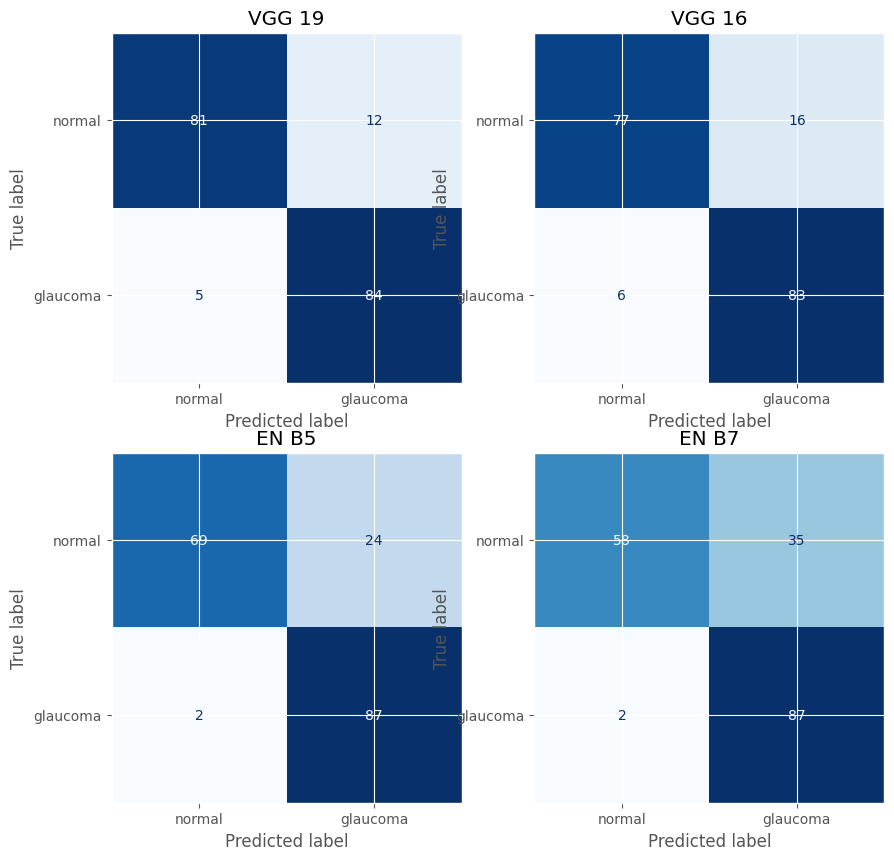

In [ ]:
plot_conf_matrix(g_y_test, g_vgg_19_y_pred, g_vgg_16_y_pred, g_en_b5_y_pred, g_en_b7_y_pred, "glaucoma")

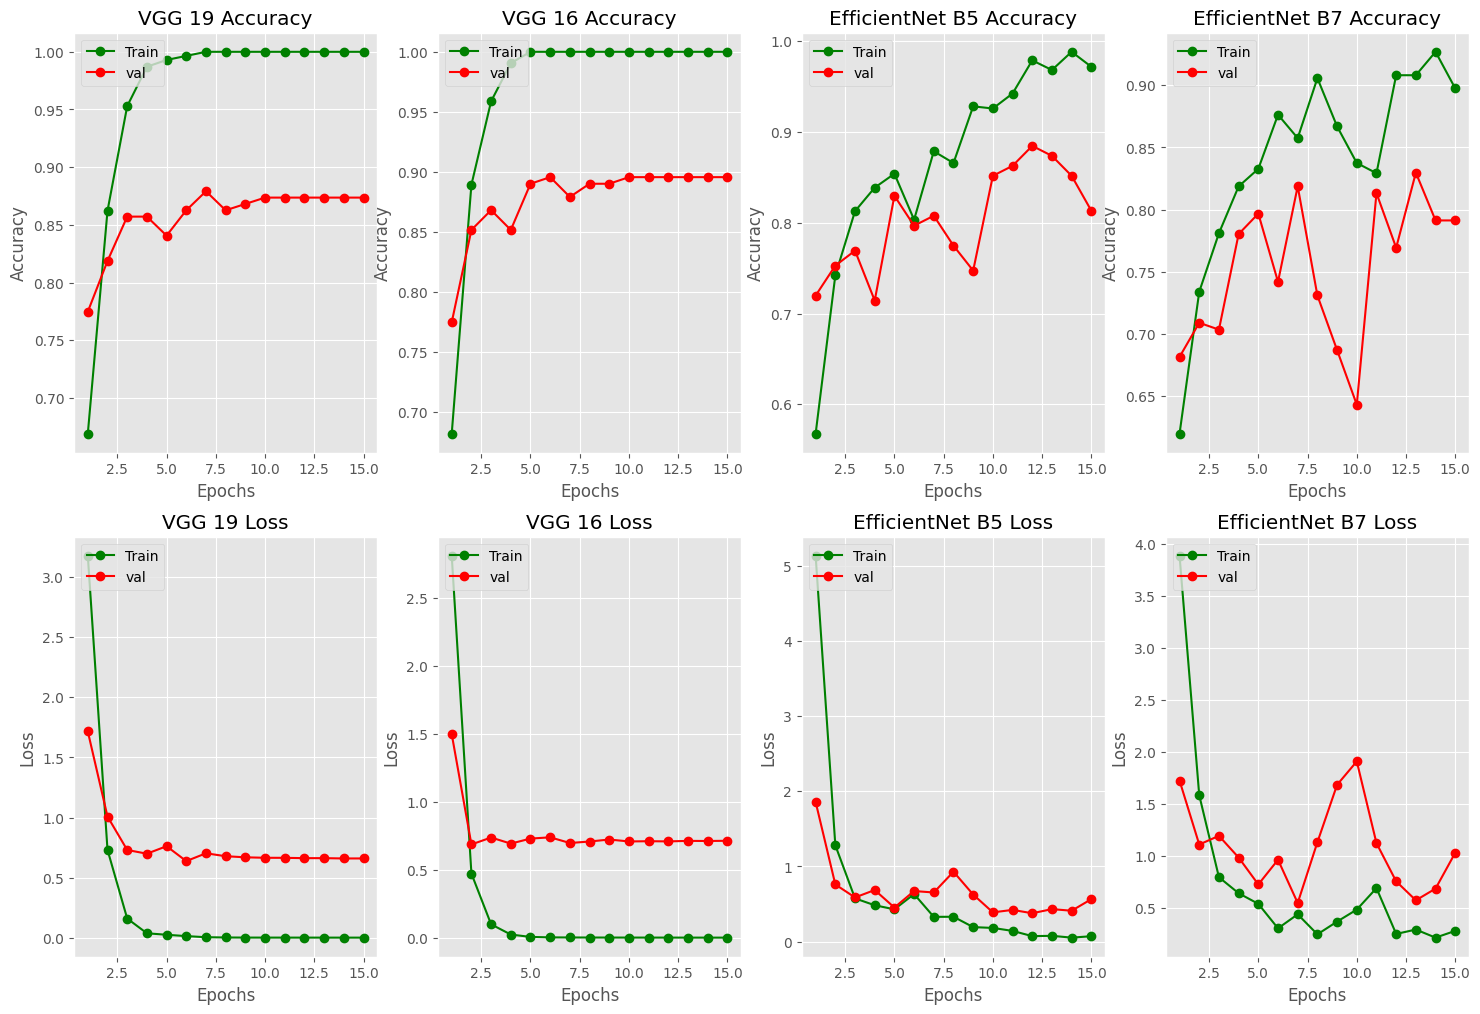

In [ ]:
plot_accuracy_and_loss(g_vgg_19_history, g_vgg_16_history, g_en_b5_history, g_en_b7_history)

### Cataract

In [ ]:
c_x_train,c_x_test,c_x_val, c_y_val,c_y_train,c_y_test=get_train_val_test_data(c_dataset, 0.7)
print(len(c_x_train),len(c_x_test),len(c_x_val), len(c_y_val),len(c_y_train),len(c_y_test))

824 177 177 177 824 177


In [ ]:
print(len(myopia))

485


In [ ]:
c_vgg_19=init_vgg_19_model()
c_vgg_16=init_vgg_16_model()
c_en_b5=init_en_b5_model()
c_en_b7=init_en_b7_model()

In [ ]:
c_vgg_19_model = init_model(c_vgg_19)
c_vgg_16_model = init_model(c_vgg_16)
c_en_b5_model = init_model(c_en_b5)
c_en_b7_model = init_model(c_en_b7)

In [ ]:
c_vgg_19_callbacks=get_callbacks("cataract_vgg19")
c_vgg_16_callbacks=get_callbacks("cataract_vgg16")
c_en_b5_callbacks=get_callbacks("cataract_efficient_net_b5")
c_en_b7_callbacks=get_callbacks("cataract_efficient_net_b7")

In [ ]:
c_vgg_19_history=train_model(c_vgg_19_model, c_x_train, c_y_train, c_x_val, c_y_val, c_vgg_19_callbacks)

Epoch 1/15
26/26 [==============================] - ETA: 0s - loss: 2.0867 - accuracy: 0.8592

26/26 [==============================] - 9s 312ms/step - loss: 2.0867 - accuracy: 0.8592 - val_loss: 1.3833 - val_accuracy: 0.9379
Epoch 2/15
26/26 [==============================] - ETA: 0s - loss: 0.7247 - accuracy: 0.9575

26/26 [==============================] - 5s 201ms/step - loss: 0.7247 - accuracy: 0.9575 - val_loss: 0.7283 - val_accuracy: 0.9492
Epoch 3/15
26/26 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9842

26/26 [==============================] - 5s 203ms/step - loss: 0.1312 - accuracy: 0.9842 - val_loss: 0.8217 - val_accuracy: 0.9153
Epoch 4/15
26/26 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9879

26/26 [==============================] - 5s 203ms/step - loss: 0.0515 - accuracy: 0.9879 - val_loss: 0.5490 - val_accuracy: 0.9322
Epoch 5/15
26/26 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

26/26 [==============================] - 5s 204ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.5019 - val_accuracy: 0.9605
Epoch 6/15
26/26 [==============================] - ETA: 0s - loss: 2.4769e-04 - accuracy: 1.0000

26/26 [==============================] - 5s 195ms/step - loss: 2.4769e-04 - accuracy: 1.0000 - val_loss: 0.5146 - val_accuracy: 0.9605
Epoch 7/15
26/26 [==============================] - ETA: 0s - loss: 1.9415e-04 - accuracy: 1.0000

26/26 [==============================] - 5s 210ms/step - loss: 1.9415e-04 - accuracy: 1.0000 - val_loss: 0.5175 - val_accuracy: 0.9605
Epoch 8/15
26/26 [==============================] - ETA: 0s - loss: 1.5818e-04 - accuracy: 1.0000

26/26 [==============================] - 5s 200ms/step - loss: 1.5818e-04 - accuracy: 1.0000 - val_loss: 0.5199 - val_accuracy: 0.9605
Epoch 9/15
26/26 [==============================] - ETA: 0s - loss: 1.3309e-04 - accuracy: 1.0000

26/26 [==============================] - 5s 201ms/step - loss: 1.3309e-04 - accuracy: 1.0000 - val_loss: 0.5223 - val_accuracy: 0.9605
Epoch 10/15
26/26 [==============================] - ETA: 0s - loss: 1.3055e-04 - accuracy: 1.0000

26/26 [==============================] - 6s 215ms/step - loss: 1.3055e-04 - accuracy: 1.0000 - val_loss: 0.5252 - val_accuracy: 0.9605
Epoch 11/15
26/26 [==============================] - ETA: 0s - loss: 1.0565e-04 - accuracy: 1.0000

26/26 [==============================] - 6s 217ms/step - loss: 1.0565e-04 - accuracy: 1.0000 - val_loss: 0.5245 - val_accuracy: 0.9605
Epoch 12/15
26/26 [==============================] - ETA: 0s - loss: 1.0068e-04 - accuracy: 1.0000

26/26 [==============================] - 5s 202ms/step - loss: 1.0068e-04 - accuracy: 1.0000 - val_loss: 0.5256 - val_accuracy: 0.9605
Epoch 13/15
26/26 [==============================] - ETA: 0s - loss: 9.4534e-05 - accuracy: 1.0000

26/26 [==============================] - 5s 200ms/step - loss: 9.4534e-05 - accuracy: 1.0000 - val_loss: 0.5289 - val_accuracy: 0.9605
Epoch 14/15
26/26 [==============================] - ETA: 0s - loss: 8.9595e-05 - accuracy: 1.0000

26/26 [==============================] - 5s 212ms/step - loss: 8.9595e-05 - accuracy: 1.0000 - val_loss: 0.5305 - val_accuracy: 0.9548
Epoch 15/15
26/26 [==============================] - ETA: 0s - loss: 8.1715e-05 - accuracy: 1.0000

26/26 [==============================] - 5s 209ms/step - loss: 8.1715e-05 - accuracy: 1.0000 - val_loss: 0.5315 - val_accuracy: 0.9548


In [ ]:
c_vgg_16_history=train_model(c_vgg_16_model, c_x_train, c_y_train, c_x_val, c_y_val, c_vgg_16_callbacks)

Epoch 1/15
26/26 [==============================] - ETA: 0s - loss: 1.0312 - accuracy: 0.8932

26/26 [==============================] - 6s 195ms/step - loss: 1.0312 - accuracy: 0.8932 - val_loss: 0.4724 - val_accuracy: 0.9492
Epoch 2/15
26/26 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9733

26/26 [==============================] - 4s 156ms/step - loss: 0.1409 - accuracy: 0.9733 - val_loss: 0.5636 - val_accuracy: 0.9266
Epoch 3/15
26/26 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9648

26/26 [==============================] - 4s 156ms/step - loss: 0.1801 - accuracy: 0.9648 - val_loss: 0.4424 - val_accuracy: 0.9435
Epoch 4/15
26/26 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9915

26/26 [==============================] - 5s 182ms/step - loss: 0.0349 - accuracy: 0.9915 - val_loss: 0.3457 - val_accuracy: 0.9605
Epoch 5/15
26/26 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9988

26/26 [==============================] - 4s 156ms/step - loss: 0.0020 - accuracy: 0.9988 - val_loss: 0.3359 - val_accuracy: 0.9605
Epoch 6/15
26/26 [==============================] - ETA: 0s - loss: 3.6009e-04 - accuracy: 1.0000

26/26 [==============================] - 4s 157ms/step - loss: 3.6009e-04 - accuracy: 1.0000 - val_loss: 0.3360 - val_accuracy: 0.9661
Epoch 7/15
26/26 [==============================] - ETA: 0s - loss: 3.5979e-04 - accuracy: 1.0000

26/26 [==============================] - 5s 181ms/step - loss: 3.5979e-04 - accuracy: 1.0000 - val_loss: 0.3415 - val_accuracy: 0.9718
Epoch 8/15
26/26 [==============================] - ETA: 0s - loss: 7.1465e-05 - accuracy: 1.0000

26/26 [==============================] - 5s 181ms/step - loss: 7.1465e-05 - accuracy: 1.0000 - val_loss: 0.3455 - val_accuracy: 0.9661
Epoch 9/15
26/26 [==============================] - ETA: 0s - loss: 3.3123e-05 - accuracy: 1.0000

26/26 [==============================] - 5s 181ms/step - loss: 3.3123e-05 - accuracy: 1.0000 - val_loss: 0.3411 - val_accuracy: 0.9661
Epoch 10/15
26/26 [==============================] - ETA: 0s - loss: 1.8892e-05 - accuracy: 1.0000

26/26 [==============================] - 5s 183ms/step - loss: 1.8892e-05 - accuracy: 1.0000 - val_loss: 0.3405 - val_accuracy: 0.9661
Epoch 11/15
26/26 [==============================] - ETA: 0s - loss: 1.5863e-05 - accuracy: 1.0000

26/26 [==============================] - 4s 162ms/step - loss: 1.5863e-05 - accuracy: 1.0000 - val_loss: 0.3406 - val_accuracy: 0.9661
Epoch 12/15
26/26 [==============================] - ETA: 0s - loss: 1.4450e-05 - accuracy: 1.0000

26/26 [==============================] - 4s 162ms/step - loss: 1.4450e-05 - accuracy: 1.0000 - val_loss: 0.3409 - val_accuracy: 0.9661
Epoch 13/15
26/26 [==============================] - ETA: 0s - loss: 1.3071e-05 - accuracy: 1.0000

26/26 [==============================] - 5s 184ms/step - loss: 1.3071e-05 - accuracy: 1.0000 - val_loss: 0.3411 - val_accuracy: 0.9661
Epoch 14/15
26/26 [==============================] - ETA: 0s - loss: 1.2425e-05 - accuracy: 1.0000

26/26 [==============================] - 4s 163ms/step - loss: 1.2425e-05 - accuracy: 1.0000 - val_loss: 0.3415 - val_accuracy: 0.9661
Epoch 15/15
26/26 [==============================] - ETA: 0s - loss: 1.1844e-05 - accuracy: 1.0000

26/26 [==============================] - 5s 183ms/step - loss: 1.1844e-05 - accuracy: 1.0000 - val_loss: 0.3416 - val_accuracy: 0.9661


In [ ]:
c_en_b5_history=train_model(c_en_b5_model, c_x_train, c_y_train, c_x_val, c_y_val, c_en_b5_callbacks)

Epoch 1/15
26/26 [==============================] - ETA: 0s - loss: 1.6824 - accuracy: 0.8386

26/26 [==============================] - 27s 437ms/step - loss: 1.6824 - accuracy: 0.8386 - val_loss: 0.8501 - val_accuracy: 0.9322
Epoch 2/15
26/26 [==============================] - ETA: 0s - loss: 1.0993 - accuracy: 0.9053

26/26 [==============================] - 7s 260ms/step - loss: 1.0993 - accuracy: 0.9053 - val_loss: 0.5175 - val_accuracy: 0.9379
Epoch 3/15
26/26 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.9260

26/26 [==============================] - 7s 260ms/step - loss: 0.5430 - accuracy: 0.9260 - val_loss: 0.2091 - val_accuracy: 0.9774
Epoch 4/15
26/26 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.9551

26/26 [==============================] - 7s 263ms/step - loss: 0.2147 - accuracy: 0.9551 - val_loss: 0.2937 - val_accuracy: 0.9435
Epoch 5/15
26/26 [==============================] - ETA: 0s - loss: 0.1893 - accuracy: 0.9636

26/26 [==============================] - 7s 262ms/step - loss: 0.1893 - accuracy: 0.9636 - val_loss: 0.1745 - val_accuracy: 0.9492
Epoch 6/15
26/26 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.9709

26/26 [==============================] - 7s 259ms/step - loss: 0.1062 - accuracy: 0.9709 - val_loss: 0.2402 - val_accuracy: 0.9605
Epoch 7/15
26/26 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9769

26/26 [==============================] - 7s 260ms/step - loss: 0.0740 - accuracy: 0.9769 - val_loss: 0.2119 - val_accuracy: 0.9661
Epoch 8/15
26/26 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.9648

26/26 [==============================] - 7s 256ms/step - loss: 0.0961 - accuracy: 0.9648 - val_loss: 0.1302 - val_accuracy: 0.9661
Epoch 9/15
26/26 [==============================] - ETA: 0s - loss: 0.0901 - accuracy: 0.9745

26/26 [==============================] - 7s 253ms/step - loss: 0.0901 - accuracy: 0.9745 - val_loss: 0.2079 - val_accuracy: 0.9605
Epoch 10/15
26/26 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9927

26/26 [==============================] - 7s 262ms/step - loss: 0.0200 - accuracy: 0.9927 - val_loss: 0.1563 - val_accuracy: 0.9605
Epoch 11/15
26/26 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9854

26/26 [==============================] - 6s 251ms/step - loss: 0.0370 - accuracy: 0.9854 - val_loss: 0.1589 - val_accuracy: 0.9718
Epoch 12/15
26/26 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9939

26/26 [==============================] - 7s 255ms/step - loss: 0.0148 - accuracy: 0.9939 - val_loss: 0.1511 - val_accuracy: 0.9605
Epoch 13/15
26/26 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9939

26/26 [==============================] - 6s 250ms/step - loss: 0.0159 - accuracy: 0.9939 - val_loss: 0.1936 - val_accuracy: 0.9492
Epoch 14/15
26/26 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9964

26/26 [==============================] - 7s 255ms/step - loss: 0.0104 - accuracy: 0.9964 - val_loss: 0.1513 - val_accuracy: 0.9548
Epoch 15/15
26/26 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9988

26/26 [==============================] - 6s 251ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.1380 - val_accuracy: 0.9548


In [ ]:
c_en_b7_history=train_model(c_en_b7_model, c_x_train, c_y_train, c_x_val, c_y_val, c_en_b7_callbacks)

Epoch 1/15
26/26 [==============================] - ETA: 0s - loss: 1.9050 - accuracy: 0.8337

26/26 [==============================] - 41s 752ms/step - loss: 1.9050 - accuracy: 0.8337 - val_loss: 0.5673 - val_accuracy: 0.9379
Epoch 2/15
26/26 [==============================] - ETA: 0s - loss: 0.7444 - accuracy: 0.9163

26/26 [==============================] - 12s 451ms/step - loss: 0.7444 - accuracy: 0.9163 - val_loss: 0.5001 - val_accuracy: 0.9322
Epoch 3/15
26/26 [==============================] - ETA: 0s - loss: 0.4156 - accuracy: 0.9417

26/26 [==============================] - 12s 479ms/step - loss: 0.4156 - accuracy: 0.9417 - val_loss: 0.2385 - val_accuracy: 0.9492
Epoch 4/15
26/26 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9563

26/26 [==============================] - 12s 448ms/step - loss: 0.1798 - accuracy: 0.9563 - val_loss: 0.1903 - val_accuracy: 0.9605
Epoch 5/15
26/26 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.9672

26/26 [==============================] - 11s 442ms/step - loss: 0.1305 - accuracy: 0.9672 - val_loss: 0.2654 - val_accuracy: 0.9492
Epoch 6/15
26/26 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9709

26/26 [==============================] - 11s 443ms/step - loss: 0.1057 - accuracy: 0.9709 - val_loss: 0.1051 - val_accuracy: 0.9831
Epoch 7/15
26/26 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9745

26/26 [==============================] - 12s 461ms/step - loss: 0.0742 - accuracy: 0.9745 - val_loss: 0.1073 - val_accuracy: 0.9831
Epoch 8/15
26/26 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9733

26/26 [==============================] - 11s 439ms/step - loss: 0.1013 - accuracy: 0.9733 - val_loss: 0.1324 - val_accuracy: 0.9718
Epoch 9/15
26/26 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9806

26/26 [==============================] - 11s 443ms/step - loss: 0.0675 - accuracy: 0.9806 - val_loss: 0.1507 - val_accuracy: 0.9605
Epoch 10/15
26/26 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9636

26/26 [==============================] - 12s 468ms/step - loss: 0.1823 - accuracy: 0.9636 - val_loss: 0.3928 - val_accuracy: 0.9435
Epoch 11/15
26/26 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 0.9745

26/26 [==============================] - 11s 446ms/step - loss: 0.1025 - accuracy: 0.9745 - val_loss: 0.1625 - val_accuracy: 0.9605
Epoch 12/15
26/26 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9879

26/26 [==============================] - 11s 443ms/step - loss: 0.0472 - accuracy: 0.9879 - val_loss: 0.1503 - val_accuracy: 0.9548
Epoch 13/15
26/26 [==============================] - ETA: 0s - loss: 0.2918 - accuracy: 0.9357

26/26 [==============================] - 12s 464ms/step - loss: 0.2918 - accuracy: 0.9357 - val_loss: 0.4876 - val_accuracy: 0.9379
Epoch 14/15
26/26 [==============================] - ETA: 0s - loss: 0.3080 - accuracy: 0.9369

26/26 [==============================] - 11s 441ms/step - loss: 0.3080 - accuracy: 0.9369 - val_loss: 0.1780 - val_accuracy: 0.9718
Epoch 15/15
26/26 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9624

26/26 [==============================] - 11s 442ms/step - loss: 0.1792 - accuracy: 0.9624 - val_loss: 0.1663 - val_accuracy: 0.9718


In [ ]:
c_vgg_19_loss, c_vgg_19_accuracy = get_loss_and_accuracy(c_vgg_19_model, c_x_val, c_y_val)
c_vgg_16_loss, c_vgg_16_accuracy = get_loss_and_accuracy(c_vgg_16_model, c_x_val, c_y_val)
c_en_b5_loss, c_en_b5_accuracy = get_loss_and_accuracy(c_en_b5_model, c_x_val, c_y_val)
c_en_b7_loss, c_en_b7_accuracy = get_loss_and_accuracy(c_en_b7_model, c_x_val, c_y_val)
print("Cataract Losses:")
print("VGG_19: " ,c_vgg_19_loss)
print("VGG_16: " ,c_vgg_16_loss)
print("EfficientNet B5: " ,c_en_b5_loss)
print("EfficientNet B7: " ,c_en_b7_loss)

print("\nCataract Accuracy:")
print("VGG_19: " ,c_vgg_19_accuracy)
print("VGG_16: " ,c_vgg_16_accuracy)
print("EfficientNet_B5: " ,c_en_b5_accuracy)
print("EfficientNet_B7: " ,c_en_b7_accuracy)

6/6 [==============================] - 2s 323ms/step - loss: 0.1663 - accuracy: 0.9718
Cataract Losses:
VGG_19:  0.5315048098564148
VGG_16:  0.34155264496803284
EfficientNet B5:  0.1380111575126648
EfficientNet B7:  0.16628704965114594

Cataract Accuracy:
VGG_19:  0.9548022747039795
VGG_16:  0.9661017060279846
EfficientNet_B5:  0.9548022747039795
EfficientNet_B7:  0.9717513918876648


In [ ]:
c_vgg_19_y_pred = predict(c_vgg_19_model, c_x_test)
c_vgg_16_y_pred = predict(c_vgg_16_model, c_x_test)
c_en_b5_y_pred = predict(c_en_b5_model, c_x_test)
c_en_b7_y_pred = predict(c_en_b7_model, c_x_test)

6/6 [==============================] - 6s 332ms/step


In [ ]:
save_model(c_vgg_19_model, "c_vgg_19_model")
save_model(c_vgg_16_model, "c_vgg_16_model")
save_model(c_en_b5_model, "c_en_b5_model")
save_model(c_en_b7_model, "c_en_b7_model")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print("Cataract Accuracy:")
print("VGG_19: ", get_accuracy_score(c_y_test,c_vgg_19_y_pred))
print("VGG_16: ", get_accuracy_score(c_y_test,c_vgg_16_y_pred))
print("EN_B5: ", get_accuracy_score(c_y_test,c_en_b5_y_pred))
print("EN_B7: ", get_accuracy_score(c_y_test,c_en_b7_y_pred))

Cataract Accuracy:
VGG_19:  0.9548022598870056
VGG_16:  0.96045197740113
EN_B5:  0.9717514124293786
EN_B7:  0.9548022598870056


In [ ]:
print(get_classification_report(c_y_test,c_vgg_19_y_pred))
print(get_classification_report(c_y_test,c_vgg_16_y_pred))
print(get_classification_report(c_y_test,c_en_b5_y_pred))
print(get_classification_report(c_y_test,c_en_b7_y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        87
           1       0.94      0.98      0.96        90

    accuracy                           0.95       177
   macro avg       0.96      0.95      0.95       177
weighted avg       0.96      0.95      0.95       177

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        87
           1       0.96      0.97      0.96        90

    accuracy                           0.96       177
   macro avg       0.96      0.96      0.96       177
weighted avg       0.96      0.96      0.96       177

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        87
           1       0.99      0.96      0.97        90

    accuracy                           0.97       177
   macro avg       0.97      0.97      0.97       177
weighted avg       0.97      0.97      0.97       177

              preci

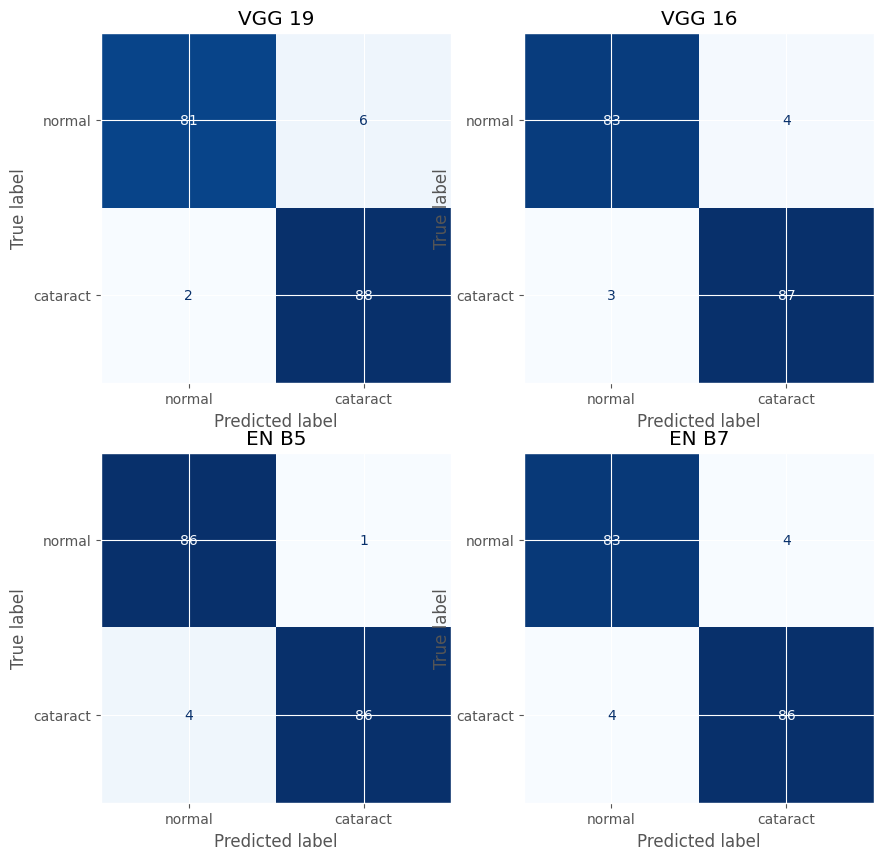

In [ ]:
plot_conf_matrix(c_y_test, c_vgg_19_y_pred, c_vgg_16_y_pred, c_en_b5_y_pred, c_en_b7_y_pred, "cataract")

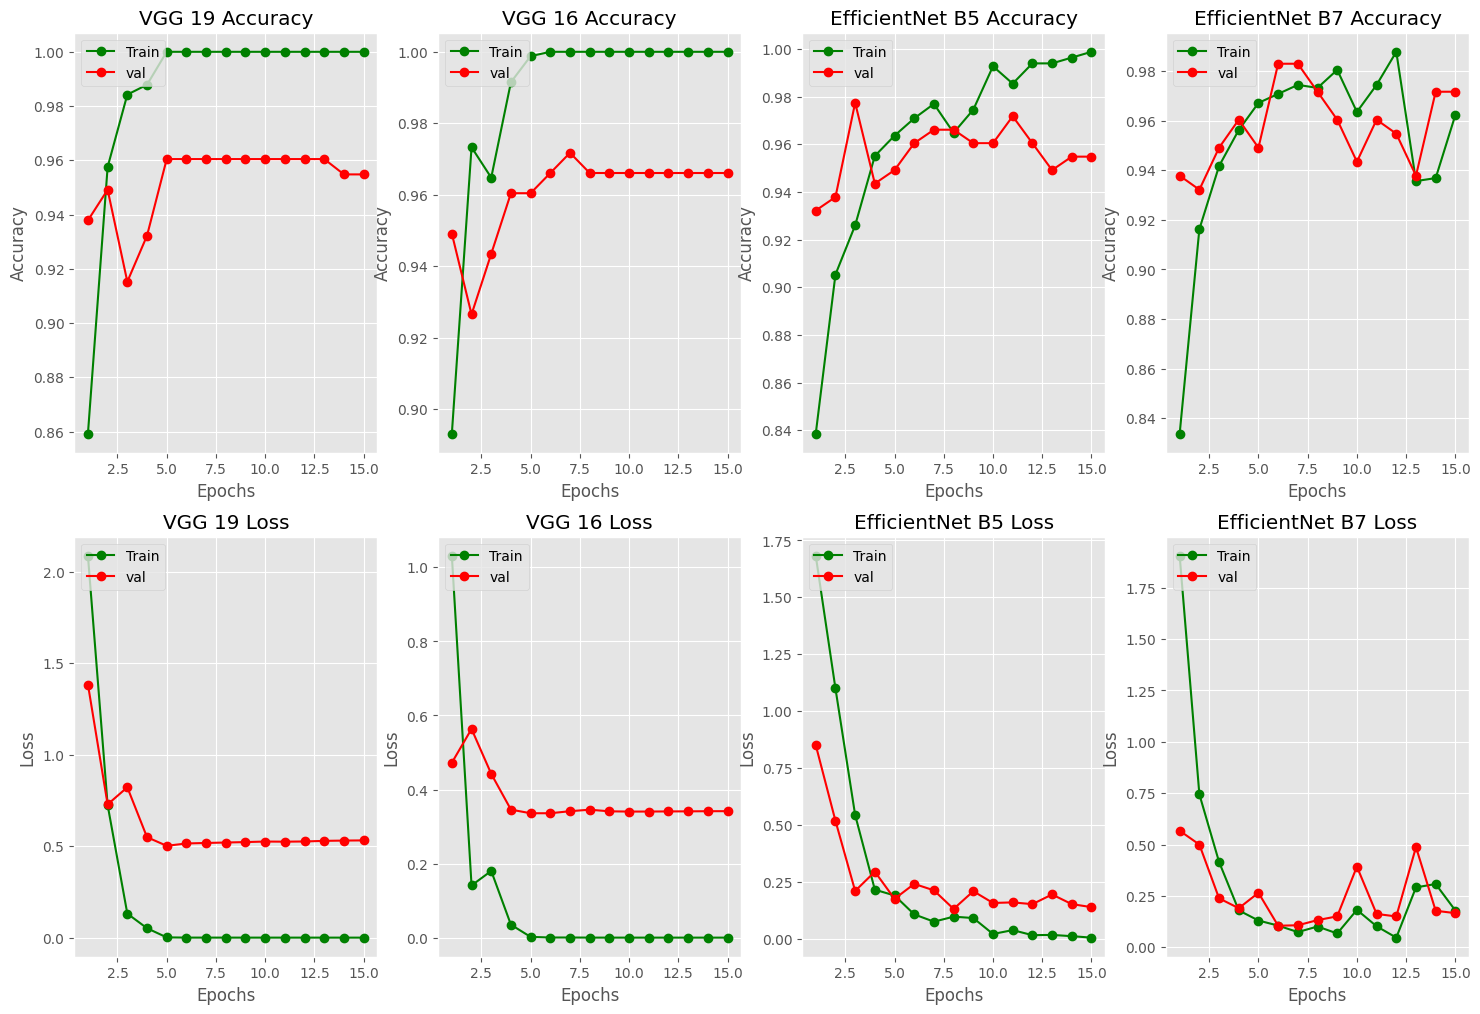

In [ ]:
plot_accuracy_and_loss(c_vgg_19_history, c_vgg_16_history, c_en_b5_history, c_en_b7_history)

### Age-related macular degeneration

In [ ]:
armd_x_train,armd_x_test,armd_x_val, armd_y_val,armd_y_train,armd_y_test=get_train_val_test_data(armd_dataset, 0.7)

In [ ]:
armd_vgg_19=init_vgg_19_model()
armd_vgg_16=init_vgg_16_model()
armd_en_b5=init_en_b5_model()
armd_en_b7=init_en_b7_model()

In [ ]:
armd_vgg_19_model = init_model(armd_vgg_19)
armd_vgg_16_model = init_model(armd_vgg_16)
armd_en_b5_model = init_model(armd_en_b5)
armd_en_b7_model = init_model(armd_en_b7)

In [ ]:
armd_vgg_19_callbacks=get_callbacks("armd_vgg19")
armd_vgg_16_callbacks=get_callbacks("armd_vgg16")
armd_en_b5_callbacks=get_callbacks("armd_efficient_net_b5")
armd_en_b7_callbacks=get_callbacks("armd_efficient_net_b7")

In [ ]:
armd_vgg_19_history=train_model(armd_vgg_19_model, armd_x_train, armd_y_train, armd_x_val, armd_y_val, armd_vgg_19_callbacks)

Epoch 1/15
25/25 [==============================] - ETA: 0s - loss: 4.4965 - accuracy: 0.5805

25/25 [==============================] - 8s 292ms/step - loss: 4.4965 - accuracy: 0.5805 - val_loss: 2.0449 - val_accuracy: 0.7229
Epoch 2/15
24/25 [===========================>..] - ETA: 0s - loss: 0.7498 - accuracy: 0.8542

25/25 [==============================] - 5s 190ms/step - loss: 0.7479 - accuracy: 0.8545 - val_loss: 2.1169 - val_accuracy: 0.6867
Epoch 3/15
24/25 [===========================>..] - ETA: 0s - loss: 0.2637 - accuracy: 0.9258

25/25 [==============================] - 5s 210ms/step - loss: 0.2706 - accuracy: 0.9247 - val_loss: 0.9951 - val_accuracy: 0.8253
Epoch 4/15
24/25 [===========================>..] - ETA: 0s - loss: 0.3179 - accuracy: 0.9323

25/25 [==============================] - 5s 214ms/step - loss: 0.3170 - accuracy: 0.9325 - val_loss: 1.1164 - val_accuracy: 0.8313
Epoch 5/15
24/25 [===========================>..] - ETA: 0s - loss: 0.0724 - accuracy: 0.9714

25/25 [==============================] - 5s 213ms/step - loss: 0.0722 - accuracy: 0.9714 - val_loss: 0.9045 - val_accuracy: 0.8554
Epoch 6/15
24/25 [===========================>..] - ETA: 0s - loss: 0.0187 - accuracy: 0.9922

25/25 [==============================] - 5s 198ms/step - loss: 0.0187 - accuracy: 0.9922 - val_loss: 1.0740 - val_accuracy: 0.8193
Epoch 7/15
24/25 [===========================>..] - ETA: 0s - loss: 0.0048 - accuracy: 0.9987

25/25 [==============================] - 5s 213ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.9220 - val_accuracy: 0.8313
Epoch 8/15
24/25 [===========================>..] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

25/25 [==============================] - 5s 214ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.9541 - val_accuracy: 0.8434
Epoch 9/15
24/25 [===========================>..] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

25/25 [==============================] - 5s 212ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.9650 - val_accuracy: 0.8373
Epoch 10/15
24/25 [===========================>..] - ETA: 0s - loss: 6.6506e-04 - accuracy: 1.0000

25/25 [==============================] - 5s 192ms/step - loss: 6.6333e-04 - accuracy: 1.0000 - val_loss: 0.9424 - val_accuracy: 0.8373
Epoch 11/15
24/25 [===========================>..] - ETA: 0s - loss: 5.7586e-04 - accuracy: 1.0000

25/25 [==============================] - 5s 190ms/step - loss: 5.7637e-04 - accuracy: 1.0000 - val_loss: 0.9419 - val_accuracy: 0.8434
Epoch 12/15
24/25 [===========================>..] - ETA: 0s - loss: 5.3513e-04 - accuracy: 1.0000

25/25 [==============================] - 5s 208ms/step - loss: 5.3657e-04 - accuracy: 1.0000 - val_loss: 0.9437 - val_accuracy: 0.8373
Epoch 13/15
24/25 [===========================>..] - ETA: 0s - loss: 5.0446e-04 - accuracy: 1.0000

25/25 [==============================] - 5s 205ms/step - loss: 5.0988e-04 - accuracy: 1.0000 - val_loss: 0.9358 - val_accuracy: 0.8373
Epoch 14/15
24/25 [===========================>..] - ETA: 0s - loss: 4.8488e-04 - accuracy: 1.0000

25/25 [==============================] - 5s 205ms/step - loss: 4.8362e-04 - accuracy: 1.0000 - val_loss: 0.9451 - val_accuracy: 0.8434
Epoch 15/15
24/25 [===========================>..] - ETA: 0s - loss: 4.5529e-04 - accuracy: 1.0000

25/25 [==============================] - 5s 189ms/step - loss: 4.5573e-04 - accuracy: 1.0000 - val_loss: 0.9445 - val_accuracy: 0.8494


In [ ]:
armd_vgg_16_history=train_model(armd_vgg_16_model, armd_x_train, armd_y_train, armd_x_val, armd_y_val, armd_vgg_16_callbacks)

Epoch 1/15
24/25 [===========================>..] - ETA: 0s - loss: 2.4173 - accuracy: 0.6315

25/25 [==============================] - 5s 183ms/step - loss: 2.4308 - accuracy: 0.6299 - val_loss: 0.9848 - val_accuracy: 0.7771
Epoch 2/15
24/25 [===========================>..] - ETA: 0s - loss: 0.9941 - accuracy: 0.8047

25/25 [==============================] - 4s 178ms/step - loss: 0.9974 - accuracy: 0.8039 - val_loss: 0.6703 - val_accuracy: 0.8494
Epoch 3/15
24/25 [===========================>..] - ETA: 0s - loss: 1.1367 - accuracy: 0.8268

25/25 [==============================] - 4s 152ms/step - loss: 1.1345 - accuracy: 0.8273 - val_loss: 1.5846 - val_accuracy: 0.7470
Epoch 4/15
24/25 [===========================>..] - ETA: 0s - loss: 0.3234 - accuracy: 0.9219

25/25 [==============================] - 4s 155ms/step - loss: 0.3226 - accuracy: 0.9221 - val_loss: 0.7149 - val_accuracy: 0.8795
Epoch 5/15
24/25 [===========================>..] - ETA: 0s - loss: 0.0516 - accuracy: 0.9805

25/25 [==============================] - 5s 183ms/step - loss: 0.0515 - accuracy: 0.9805 - val_loss: 0.6023 - val_accuracy: 0.8916
Epoch 6/15
24/25 [===========================>..] - ETA: 0s - loss: 0.0077 - accuracy: 0.9974

25/25 [==============================] - 5s 184ms/step - loss: 0.0077 - accuracy: 0.9974 - val_loss: 0.6145 - val_accuracy: 0.9036
Epoch 7/15
24/25 [===========================>..] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

25/25 [==============================] - 5s 185ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.5975 - val_accuracy: 0.9036
Epoch 8/15
24/25 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

25/25 [==============================] - 5s 185ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.6041 - val_accuracy: 0.9036
Epoch 9/15
24/25 [===========================>..] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

25/25 [==============================] - 4s 159ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.6039 - val_accuracy: 0.9036
Epoch 10/15
24/25 [===========================>..] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

25/25 [==============================] - 4s 182ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.6068 - val_accuracy: 0.9036
Epoch 11/15
24/25 [===========================>..] - ETA: 0s - loss: 9.5473e-04 - accuracy: 1.0000

25/25 [==============================] - 4s 182ms/step - loss: 9.5295e-04 - accuracy: 1.0000 - val_loss: 0.6093 - val_accuracy: 0.9096
Epoch 12/15
24/25 [===========================>..] - ETA: 0s - loss: 8.6846e-04 - accuracy: 1.0000

25/25 [==============================] - 4s 180ms/step - loss: 8.6922e-04 - accuracy: 1.0000 - val_loss: 0.6126 - val_accuracy: 0.9096
Epoch 13/15
24/25 [===========================>..] - ETA: 0s - loss: 8.1003e-04 - accuracy: 1.0000

25/25 [==============================] - 4s 156ms/step - loss: 8.0796e-04 - accuracy: 1.0000 - val_loss: 0.6090 - val_accuracy: 0.9096
Epoch 14/15
24/25 [===========================>..] - ETA: 0s - loss: 7.5150e-04 - accuracy: 1.0000

25/25 [==============================] - 4s 181ms/step - loss: 7.4982e-04 - accuracy: 1.0000 - val_loss: 0.6103 - val_accuracy: 0.9096
Epoch 15/15
24/25 [===========================>..] - ETA: 0s - loss: 7.0232e-04 - accuracy: 1.0000

25/25 [==============================] - 4s 179ms/step - loss: 7.0050e-04 - accuracy: 1.0000 - val_loss: 0.6103 - val_accuracy: 0.9096


In [ ]:
armd_en_b5_history=train_model(armd_en_b5_model, armd_x_train, armd_y_train, armd_x_val, armd_y_val, armd_en_b5_callbacks)

Epoch 1/15
24/25 [===========================>..] - ETA: 0s - loss: 3.6396 - accuracy: 0.5638

25/25 [==============================] - 26s 443ms/step - loss: 3.6304 - accuracy: 0.5649 - val_loss: 2.1486 - val_accuracy: 0.6988
Epoch 2/15
24/25 [===========================>..] - ETA: 0s - loss: 2.0105 - accuracy: 0.6732

25/25 [==============================] - 6s 257ms/step - loss: 2.0053 - accuracy: 0.6740 - val_loss: 1.5754 - val_accuracy: 0.7108
Epoch 3/15
24/25 [===========================>..] - ETA: 0s - loss: 0.7644 - accuracy: 0.8008

25/25 [==============================] - 6s 256ms/step - loss: 0.7802 - accuracy: 0.8000 - val_loss: 0.7128 - val_accuracy: 0.7651
Epoch 4/15
24/25 [===========================>..] - ETA: 0s - loss: 0.7328 - accuracy: 0.7812

25/25 [==============================] - 6s 258ms/step - loss: 0.7309 - accuracy: 0.7818 - val_loss: 1.3056 - val_accuracy: 0.7229
Epoch 5/15
24/25 [===========================>..] - ETA: 0s - loss: 0.4152 - accuracy: 0.8451

25/25 [==============================] - 6s 260ms/step - loss: 0.4142 - accuracy: 0.8455 - val_loss: 0.6685 - val_accuracy: 0.7651
Epoch 6/15
24/25 [===========================>..] - ETA: 0s - loss: 0.2976 - accuracy: 0.8854

25/25 [==============================] - 6s 252ms/step - loss: 0.3000 - accuracy: 0.8831 - val_loss: 0.3881 - val_accuracy: 0.8434
Epoch 7/15
24/25 [===========================>..] - ETA: 0s - loss: 0.2552 - accuracy: 0.8893

25/25 [==============================] - 6s 260ms/step - loss: 0.2554 - accuracy: 0.8883 - val_loss: 0.4018 - val_accuracy: 0.8373
Epoch 8/15
24/25 [===========================>..] - ETA: 0s - loss: 0.2853 - accuracy: 0.8828

25/25 [==============================] - 6s 256ms/step - loss: 0.2855 - accuracy: 0.8831 - val_loss: 2.0893 - val_accuracy: 0.6265
Epoch 9/15
24/25 [===========================>..] - ETA: 0s - loss: 0.8440 - accuracy: 0.7878

25/25 [==============================] - 6s 260ms/step - loss: 0.8420 - accuracy: 0.7883 - val_loss: 0.5908 - val_accuracy: 0.8133
Epoch 10/15
24/25 [===========================>..] - ETA: 0s - loss: 0.2228 - accuracy: 0.9115

25/25 [==============================] - 6s 245ms/step - loss: 0.2222 - accuracy: 0.9117 - val_loss: 1.0892 - val_accuracy: 0.6566
Epoch 11/15
24/25 [===========================>..] - ETA: 0s - loss: 0.1892 - accuracy: 0.9271

25/25 [==============================] - 6s 260ms/step - loss: 0.1888 - accuracy: 0.9273 - val_loss: 0.5924 - val_accuracy: 0.7771
Epoch 12/15
24/25 [===========================>..] - ETA: 0s - loss: 0.1629 - accuracy: 0.9271

25/25 [==============================] - 6s 245ms/step - loss: 0.1638 - accuracy: 0.9260 - val_loss: 1.2163 - val_accuracy: 0.6928
Epoch 13/15
24/25 [===========================>..] - ETA: 0s - loss: 0.6351 - accuracy: 0.8086

25/25 [==============================] - 6s 251ms/step - loss: 0.6335 - accuracy: 0.8091 - val_loss: 0.5177 - val_accuracy: 0.8133
Epoch 14/15
24/25 [===========================>..] - ETA: 0s - loss: 0.1544 - accuracy: 0.9440

25/25 [==============================] - 6s 254ms/step - loss: 0.1542 - accuracy: 0.9442 - val_loss: 0.7352 - val_accuracy: 0.7590
Epoch 15/15
24/25 [===========================>..] - ETA: 0s - loss: 0.1117 - accuracy: 0.9479

25/25 [==============================] - 6s 257ms/step - loss: 0.1124 - accuracy: 0.9468 - val_loss: 0.7116 - val_accuracy: 0.8133


In [ ]:
armd_en_b7_history=train_model(armd_en_b7_model, armd_x_train, armd_y_train, armd_x_val, armd_y_val, armd_en_b7_callbacks)

Epoch 1/15
25/25 [==============================] - ETA: 0s - loss: 2.8221 - accuracy: 0.5987

25/25 [==============================] - 40s 692ms/step - loss: 2.8221 - accuracy: 0.5987 - val_loss: 0.8505 - val_accuracy: 0.7229
Epoch 2/15
24/25 [===========================>..] - ETA: 0s - loss: 0.8800 - accuracy: 0.7448

25/25 [==============================] - 11s 461ms/step - loss: 0.8862 - accuracy: 0.7442 - val_loss: 0.9500 - val_accuracy: 0.6687
Epoch 3/15
25/25 [==============================] - ETA: 0s - loss: 0.9099 - accuracy: 0.7364

25/25 [==============================] - 12s 469ms/step - loss: 0.9099 - accuracy: 0.7364 - val_loss: 0.8014 - val_accuracy: 0.7590
Epoch 4/15
24/25 [===========================>..] - ETA: 0s - loss: 0.4790 - accuracy: 0.8359

25/25 [==============================] - 12s 467ms/step - loss: 0.4777 - accuracy: 0.8364 - val_loss: 2.1157 - val_accuracy: 0.5663
Epoch 5/15
24/25 [===========================>..] - ETA: 0s - loss: 0.5750 - accuracy: 0.8021

25/25 [==============================] - 11s 432ms/step - loss: 0.5735 - accuracy: 0.8026 - val_loss: 0.6672 - val_accuracy: 0.7771
Epoch 6/15
24/25 [===========================>..] - ETA: 0s - loss: 0.3953 - accuracy: 0.8646

25/25 [==============================] - 11s 431ms/step - loss: 0.3943 - accuracy: 0.8649 - val_loss: 0.6764 - val_accuracy: 0.7470
Epoch 7/15
24/25 [===========================>..] - ETA: 0s - loss: 0.4270 - accuracy: 0.8451

25/25 [==============================] - 11s 430ms/step - loss: 0.4259 - accuracy: 0.8455 - val_loss: 3.3293 - val_accuracy: 0.5663
Epoch 8/15
25/25 [==============================] - ETA: 0s - loss: 1.0820 - accuracy: 0.7688

25/25 [==============================] - 11s 457ms/step - loss: 1.0820 - accuracy: 0.7688 - val_loss: 1.4053 - val_accuracy: 0.6506
Epoch 9/15
24/25 [===========================>..] - ETA: 0s - loss: 0.3331 - accuracy: 0.8880

25/25 [==============================] - 11s 455ms/step - loss: 0.3325 - accuracy: 0.8883 - val_loss: 0.4148 - val_accuracy: 0.8554
Epoch 10/15
24/25 [===========================>..] - ETA: 0s - loss: 0.2282 - accuracy: 0.9141

25/25 [==============================] - 11s 430ms/step - loss: 0.2297 - accuracy: 0.9130 - val_loss: 0.8095 - val_accuracy: 0.7169
Epoch 11/15
24/25 [===========================>..] - ETA: 0s - loss: 0.4852 - accuracy: 0.8490

25/25 [==============================] - 11s 434ms/step - loss: 0.4840 - accuracy: 0.8494 - val_loss: 0.4393 - val_accuracy: 0.8795
Epoch 12/15
24/25 [===========================>..] - ETA: 0s - loss: 0.2312 - accuracy: 0.9167

25/25 [==============================] - 11s 464ms/step - loss: 0.2307 - accuracy: 0.9169 - val_loss: 0.4042 - val_accuracy: 0.8795
Epoch 13/15
25/25 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9312

25/25 [==============================] - 11s 463ms/step - loss: 0.1741 - accuracy: 0.9312 - val_loss: 0.4466 - val_accuracy: 0.8434
Epoch 14/15
25/25 [==============================] - ETA: 0s - loss: 0.2417 - accuracy: 0.9104

25/25 [==============================] - 11s 430ms/step - loss: 0.2417 - accuracy: 0.9104 - val_loss: 0.7627 - val_accuracy: 0.7651
Epoch 15/15
24/25 [===========================>..] - ETA: 0s - loss: 0.2055 - accuracy: 0.9271

25/25 [==============================] - 11s 457ms/step - loss: 0.2050 - accuracy: 0.9273 - val_loss: 0.4010 - val_accuracy: 0.8735


In [ ]:
armd_vgg_19_loss, armd_vgg_19_accuracy = get_loss_and_accuracy(armd_vgg_19_model, armd_x_val, armd_y_val)
armd_vgg_16_loss, armd_vgg_16_accuracy = get_loss_and_accuracy(armd_vgg_16_model, armd_x_val, armd_y_val)
armd_en_b5_loss, armd_en_b5_accuracy = get_loss_and_accuracy(armd_en_b5_model, armd_x_val, armd_y_val)
armd_en_b7_loss, armd_en_b7_accuracy = get_loss_and_accuracy(armd_en_b7_model, armd_x_val, armd_y_val)
print("ARMD Losses:")
print("VGG_19: " ,armd_vgg_19_loss)
print("VGG_16: " ,armd_vgg_16_loss)
print("EfficientNet B5: " ,armd_en_b5_loss)
print("EfficientNet B7: " ,armd_en_b7_loss)

print("\ARMD Accuracy:")
print("VGG_19: " ,armd_vgg_19_accuracy)
print("VGG_16: " ,armd_vgg_16_accuracy)
print("EfficientNet_B5: " ,armd_en_b5_accuracy)
print("EfficientNet_B7: " ,armd_en_b7_accuracy)

6/6 [==============================] - 2s 301ms/step - loss: 0.4010 - accuracy: 0.8735
ARMD Losses:
VGG_19:  0.9445164799690247
VGG_16:  0.6102893948554993
EfficientNet B5:  0.7115601301193237
EfficientNet B7:  0.40096843242645264
\ARMD Accuracy:
VGG_19:  0.849397599697113
VGG_16:  0.9096385836601257
EfficientNet_B5:  0.8132529854774475
EfficientNet_B7:  0.8734939694404602


In [ ]:
armd_vgg_19_y_pred = predict(armd_vgg_19_model, armd_x_test)
armd_vgg_16_y_pred = predict(armd_vgg_16_model, armd_x_test)
armd_en_b5_y_pred = predict(armd_en_b5_model, armd_x_test)
armd_en_b7_y_pred = predict(armd_en_b7_model, armd_x_test)

6/6 [==============================] - 7s 475ms/step


In [ ]:
save_model(armd_vgg_19_model, "armd_vgg_19_model")
save_model(armd_vgg_16_model, "armd_vgg_16_model")
save_model(armd_en_b5_model, "armd_en_b5_model")
save_model(armd_en_b7_model, "armd_en_b7_model")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print("ARMD Accuracy:")
print("VGG_19: ", get_accuracy_score(armd_y_test,armd_vgg_19_y_pred))
print("VGG_16: ", get_accuracy_score(armd_y_test,armd_vgg_16_y_pred))
print("EN_B5: ", get_accuracy_score(armd_y_test,armd_en_b5_y_pred))
print("EN_B7: ", get_accuracy_score(armd_y_test,armd_en_b7_y_pred))

ARMD Accuracy:
VGG_19:  0.8606060606060606
VGG_16:  0.8848484848484849
EN_B5:  0.8363636363636363
EN_B7:  0.8727272727272727


In [ ]:
print(get_classification_report(armd_y_test,armd_vgg_19_y_pred))
print(get_classification_report(armd_y_test,armd_vgg_16_y_pred))
print(get_classification_report(armd_y_test,armd_en_b5_y_pred))
print(get_classification_report(armd_y_test,armd_en_b7_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.83      0.86        83
           1       0.84      0.89      0.86        82

    accuracy                           0.86       165
   macro avg       0.86      0.86      0.86       165
weighted avg       0.86      0.86      0.86       165

              precision    recall  f1-score   support

           0       0.93      0.83      0.88        83
           1       0.85      0.94      0.89        82

    accuracy                           0.88       165
   macro avg       0.89      0.89      0.88       165
weighted avg       0.89      0.88      0.88       165

              precision    recall  f1-score   support

           0       0.76      0.98      0.86        83
           1       0.97      0.70      0.81        82

    accuracy                           0.84       165
   macro avg       0.87      0.84      0.83       165
weighted avg       0.86      0.84      0.83       165

              preci

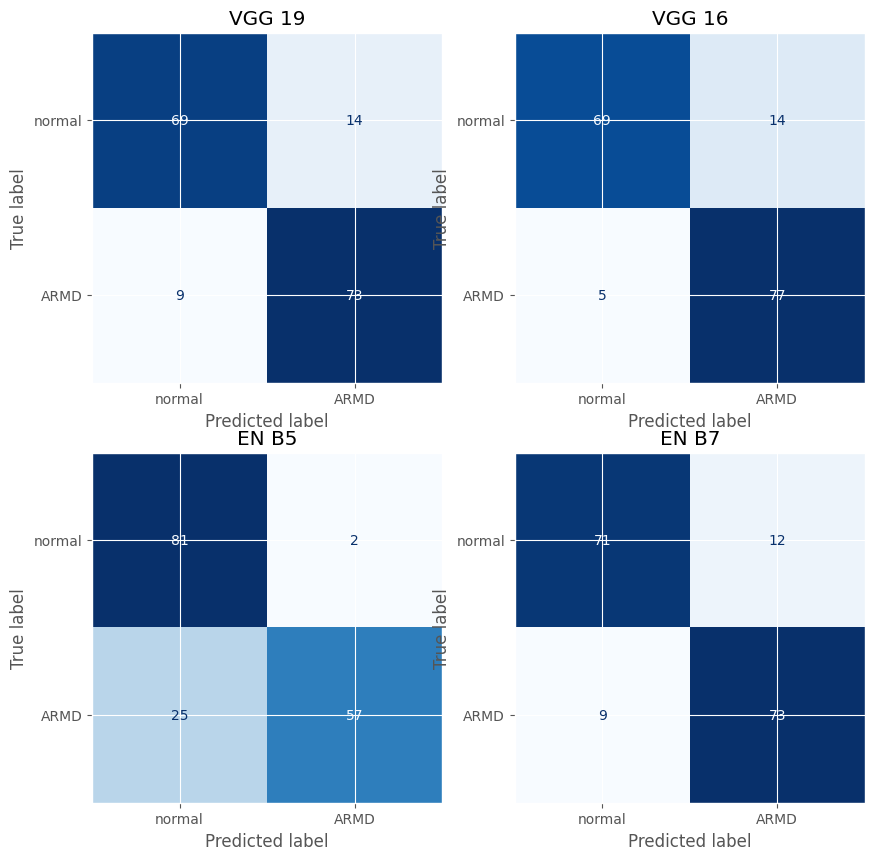

In [ ]:
plot_conf_matrix(armd_y_test, armd_vgg_19_y_pred, armd_vgg_16_y_pred, armd_en_b5_y_pred, armd_en_b7_y_pred, "ARMD")

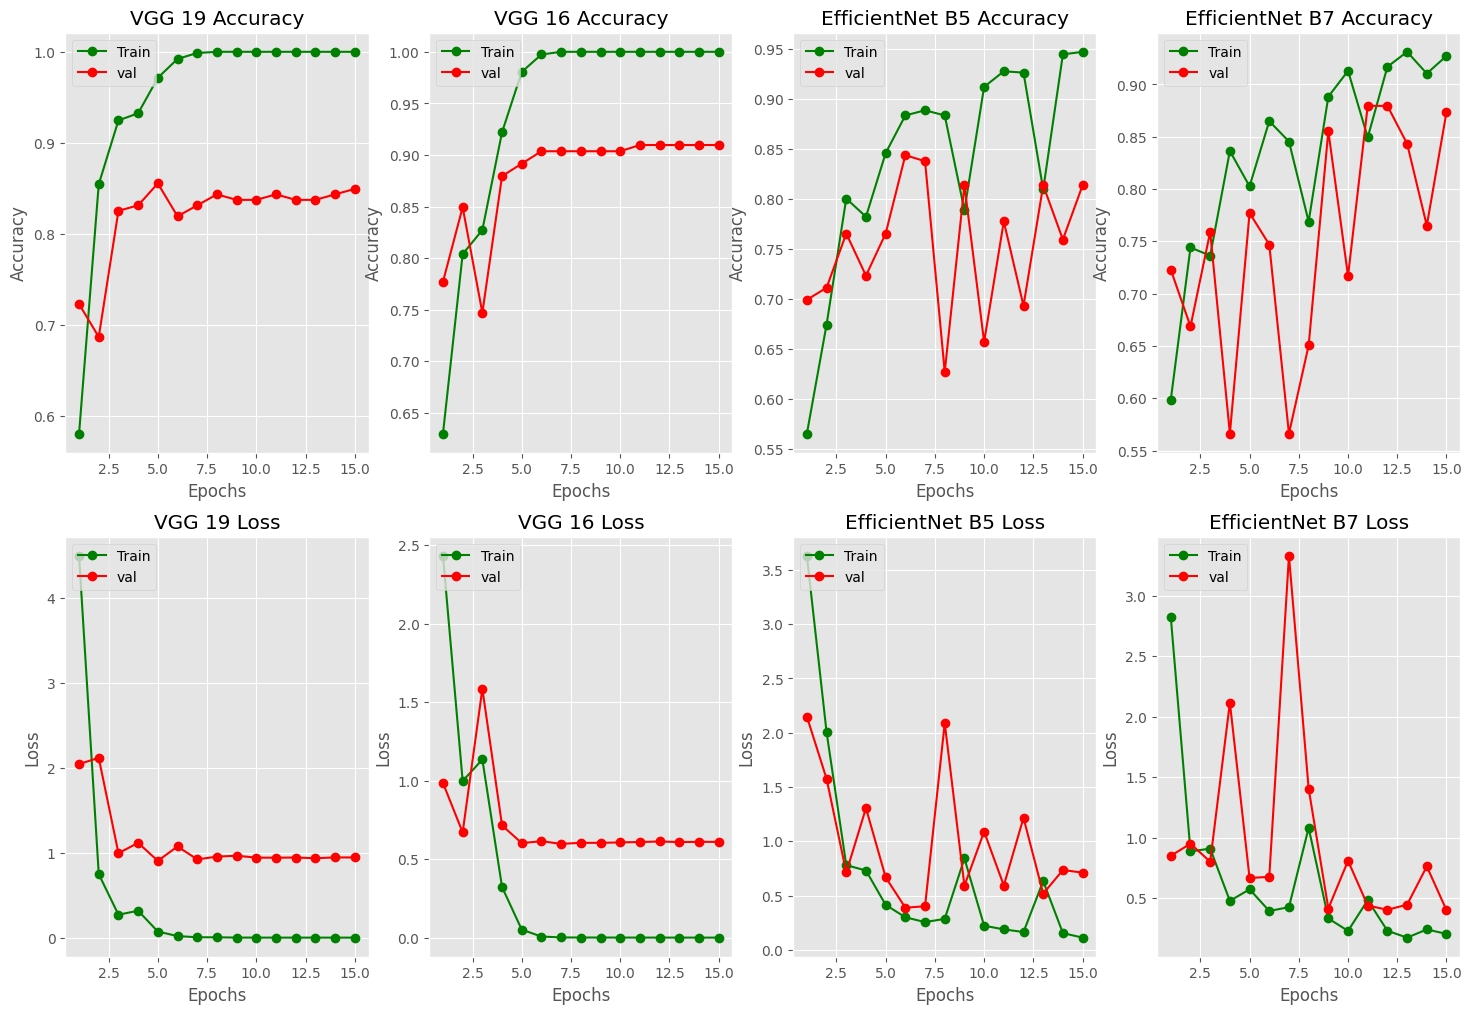

In [ ]:
plot_accuracy_and_loss(armd_vgg_19_history, armd_vgg_16_history, armd_en_b5_history, armd_en_b7_history)

### Hypertension

In [ ]:
h_x_train,h_x_test,h_x_val, h_y_val,h_y_train,h_y_test=get_train_val_test_data(h_dataset, 0.7)

In [ ]:
h_vgg_19=init_vgg_19_model()
h_vgg_16=init_vgg_16_model()
h_en_b5=init_en_b5_model()
h_en_b7=init_en_b7_model()

In [ ]:
h_vgg_19_model = init_model(h_vgg_19)
h_vgg_16_model = init_model(h_vgg_16)
h_en_b5_model = init_model(h_en_b5)
h_en_b7_model = init_model(h_en_b7)

In [ ]:
h_vgg_19_callbacks=get_callbacks("h_vgg19")
h_vgg_16_callbacks=get_callbacks("h_vgg16")
h_en_b5_callbacks=get_callbacks("h_efficient_net_b5")
h_en_b7_callbacks=get_callbacks("h_efficient_net_b7")

In [ ]:
h_vgg_19_history=train_model(h_vgg_19_model, h_x_train, h_y_train, h_x_val, h_y_val, h_vgg_19_callbacks)

Epoch 1/15
16/16 [==============================] - ETA: 0s - loss: 6.1701 - accuracy: 0.5793

16/16 [==============================] - 10s 572ms/step - loss: 6.1701 - accuracy: 0.5793 - val_loss: 6.0112 - val_accuracy: 0.5364
Epoch 2/15
16/16 [==============================] - ETA: 0s - loss: 1.9621 - accuracy: 0.7515

16/16 [==============================] - 3s 207ms/step - loss: 1.9621 - accuracy: 0.7515 - val_loss: 2.1580 - val_accuracy: 0.7273
Epoch 3/15
16/16 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.8591

16/16 [==============================] - 3s 208ms/step - loss: 0.7310 - accuracy: 0.8591 - val_loss: 1.4752 - val_accuracy: 0.8000
Epoch 4/15
16/16 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9295

16/16 [==============================] - 3s 208ms/step - loss: 0.2556 - accuracy: 0.9295 - val_loss: 2.6368 - val_accuracy: 0.7091
Epoch 5/15
16/16 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.9609

16/16 [==============================] - 3s 210ms/step - loss: 0.1134 - accuracy: 0.9609 - val_loss: 1.8152 - val_accuracy: 0.8182
Epoch 6/15
16/16 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9941

16/16 [==============================] - 3s 211ms/step - loss: 0.0128 - accuracy: 0.9941 - val_loss: 1.6362 - val_accuracy: 0.8364
Epoch 7/15
16/16 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9980

16/16 [==============================] - 3s 210ms/step - loss: 0.0069 - accuracy: 0.9980 - val_loss: 1.5596 - val_accuracy: 0.7909
Epoch 8/15
16/16 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

16/16 [==============================] - 3s 208ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.5551 - val_accuracy: 0.8182
Epoch 9/15
16/16 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

16/16 [==============================] - 3s 209ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.5615 - val_accuracy: 0.8091
Epoch 10/15
16/16 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

16/16 [==============================] - 3s 203ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.5663 - val_accuracy: 0.8000
Epoch 11/15
16/16 [==============================] - ETA: 0s - loss: 8.2115e-04 - accuracy: 1.0000

16/16 [==============================] - 3s 205ms/step - loss: 8.2115e-04 - accuracy: 1.0000 - val_loss: 1.5746 - val_accuracy: 0.8091
Epoch 12/15
16/16 [==============================] - ETA: 0s - loss: 7.3414e-04 - accuracy: 1.0000

16/16 [==============================] - 3s 199ms/step - loss: 7.3414e-04 - accuracy: 1.0000 - val_loss: 1.5769 - val_accuracy: 0.8091
Epoch 13/15
16/16 [==============================] - ETA: 0s - loss: 6.7661e-04 - accuracy: 1.0000

16/16 [==============================] - 3s 204ms/step - loss: 6.7661e-04 - accuracy: 1.0000 - val_loss: 1.5772 - val_accuracy: 0.8091
Epoch 14/15
16/16 [==============================] - ETA: 0s - loss: 6.4155e-04 - accuracy: 1.0000

16/16 [==============================] - 3s 204ms/step - loss: 6.4155e-04 - accuracy: 1.0000 - val_loss: 1.5815 - val_accuracy: 0.8091
Epoch 15/15
16/16 [==============================] - ETA: 0s - loss: 5.9668e-04 - accuracy: 1.0000

16/16 [==============================] - 3s 195ms/step - loss: 5.9668e-04 - accuracy: 1.0000 - val_loss: 1.5824 - val_accuracy: 0.8091


In [ ]:
h_vgg_16_history=train_model(h_vgg_16_model, h_x_train, h_y_train, h_x_val, h_y_val, h_vgg_16_callbacks)

Epoch 1/15
16/16 [==============================] - ETA: 0s - loss: 3.7970 - accuracy: 0.5675

16/16 [==============================] - 3s 172ms/step - loss: 3.7970 - accuracy: 0.5675 - val_loss: 2.5106 - val_accuracy: 0.6364
Epoch 2/15
16/16 [==============================] - ETA: 0s - loss: 1.3300 - accuracy: 0.7926

16/16 [==============================] - 3s 172ms/step - loss: 1.3300 - accuracy: 0.7926 - val_loss: 0.9369 - val_accuracy: 0.7909
Epoch 3/15
16/16 [==============================] - ETA: 0s - loss: 0.2772 - accuracy: 0.9198

16/16 [==============================] - 3s 163ms/step - loss: 0.2772 - accuracy: 0.9198 - val_loss: 0.6238 - val_accuracy: 0.8636
Epoch 4/15
16/16 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9765

16/16 [==============================] - 3s 171ms/step - loss: 0.0578 - accuracy: 0.9765 - val_loss: 0.7647 - val_accuracy: 0.8545
Epoch 5/15
16/16 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9843

16/16 [==============================] - 2s 157ms/step - loss: 0.0338 - accuracy: 0.9843 - val_loss: 0.7869 - val_accuracy: 0.8545
Epoch 6/15
16/16 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9980

16/16 [==============================] - 2s 158ms/step - loss: 0.0089 - accuracy: 0.9980 - val_loss: 0.6914 - val_accuracy: 0.8455
Epoch 7/15
16/16 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

16/16 [==============================] - 3s 171ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.6957 - val_accuracy: 0.8455
Epoch 8/15
16/16 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

16/16 [==============================] - 3s 174ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.7009 - val_accuracy: 0.8455
Epoch 9/15
16/16 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

16/16 [==============================] - 3s 173ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.7082 - val_accuracy: 0.8455
Epoch 10/15
16/16 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

16/16 [==============================] - 3s 159ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.7106 - val_accuracy: 0.8455
Epoch 11/15
16/16 [==============================] - ETA: 0s - loss: 9.1325e-04 - accuracy: 1.0000

16/16 [==============================] - 3s 172ms/step - loss: 9.1325e-04 - accuracy: 1.0000 - val_loss: 0.7107 - val_accuracy: 0.8455
Epoch 12/15
16/16 [==============================] - ETA: 0s - loss: 8.5063e-04 - accuracy: 1.0000

16/16 [==============================] - 3s 160ms/step - loss: 8.5063e-04 - accuracy: 1.0000 - val_loss: 0.7121 - val_accuracy: 0.8455
Epoch 13/15
16/16 [==============================] - ETA: 0s - loss: 7.9439e-04 - accuracy: 1.0000

16/16 [==============================] - 3s 164ms/step - loss: 7.9439e-04 - accuracy: 1.0000 - val_loss: 0.7130 - val_accuracy: 0.8455
Epoch 14/15
16/16 [==============================] - ETA: 0s - loss: 7.4764e-04 - accuracy: 1.0000

16/16 [==============================] - 3s 175ms/step - loss: 7.4764e-04 - accuracy: 1.0000 - val_loss: 0.7150 - val_accuracy: 0.8455
Epoch 15/15
16/16 [==============================] - ETA: 0s - loss: 7.1601e-04 - accuracy: 1.0000

16/16 [==============================] - 3s 175ms/step - loss: 7.1601e-04 - accuracy: 1.0000 - val_loss: 0.7170 - val_accuracy: 0.8455


In [ ]:
h_en_b5_history=train_model(h_en_b5_model, h_x_train, h_y_train, h_x_val, h_y_val, h_en_b5_callbacks)

Epoch 1/15
16/16 [==============================] - ETA: 0s - loss: 5.8351 - accuracy: 0.5460

16/16 [==============================] - 26s 590ms/step - loss: 5.8351 - accuracy: 0.5460 - val_loss: 5.5648 - val_accuracy: 0.4909
Epoch 2/15
16/16 [==============================] - ETA: 0s - loss: 2.4539 - accuracy: 0.6204

16/16 [==============================] - 5s 294ms/step - loss: 2.4539 - accuracy: 0.6204 - val_loss: 1.5128 - val_accuracy: 0.7273
Epoch 3/15
16/16 [==============================] - ETA: 0s - loss: 1.0889 - accuracy: 0.7202

16/16 [==============================] - 4s 260ms/step - loss: 1.0889 - accuracy: 0.7202 - val_loss: 0.9253 - val_accuracy: 0.7091
Epoch 4/15
16/16 [==============================] - ETA: 0s - loss: 0.9417 - accuracy: 0.7515

16/16 [==============================] - 4s 263ms/step - loss: 0.9417 - accuracy: 0.7515 - val_loss: 0.8865 - val_accuracy: 0.7273
Epoch 5/15
16/16 [==============================] - ETA: 0s - loss: 0.6975 - accuracy: 0.7847

16/16 [==============================] - 4s 260ms/step - loss: 0.6975 - accuracy: 0.7847 - val_loss: 0.8660 - val_accuracy: 0.7545
Epoch 6/15
16/16 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.8258

16/16 [==============================] - 5s 298ms/step - loss: 0.5702 - accuracy: 0.8258 - val_loss: 0.6269 - val_accuracy: 0.7909
Epoch 7/15
16/16 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8376

16/16 [==============================] - 5s 303ms/step - loss: 0.4070 - accuracy: 0.8376 - val_loss: 0.9524 - val_accuracy: 0.7727
Epoch 8/15
16/16 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.8571

16/16 [==============================] - 4s 259ms/step - loss: 0.3459 - accuracy: 0.8571 - val_loss: 0.4694 - val_accuracy: 0.8455
Epoch 9/15
16/16 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9178

16/16 [==============================] - 4s 259ms/step - loss: 0.2168 - accuracy: 0.9178 - val_loss: 0.9198 - val_accuracy: 0.7364
Epoch 10/15
16/16 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8748

16/16 [==============================] - 4s 264ms/step - loss: 0.3578 - accuracy: 0.8748 - val_loss: 0.6787 - val_accuracy: 0.7273
Epoch 11/15
16/16 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.9022

16/16 [==============================] - 5s 294ms/step - loss: 0.2408 - accuracy: 0.9022 - val_loss: 0.6809 - val_accuracy: 0.7000
Epoch 12/15
16/16 [==============================] - ETA: 0s - loss: 0.2915 - accuracy: 0.8943

16/16 [==============================] - 4s 256ms/step - loss: 0.2915 - accuracy: 0.8943 - val_loss: 0.5400 - val_accuracy: 0.7727
Epoch 13/15
16/16 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.9452

16/16 [==============================] - 5s 302ms/step - loss: 0.1384 - accuracy: 0.9452 - val_loss: 0.7683 - val_accuracy: 0.7727
Epoch 14/15
16/16 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9432

16/16 [==============================] - 5s 293ms/step - loss: 0.1412 - accuracy: 0.9432 - val_loss: 0.5522 - val_accuracy: 0.7909
Epoch 15/15
16/16 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9706

16/16 [==============================] - 5s 292ms/step - loss: 0.0981 - accuracy: 0.9706 - val_loss: 0.5903 - val_accuracy: 0.7636


In [ ]:
h_en_b7_history=train_model(h_en_b7_model, h_x_train, h_y_train, h_x_val, h_y_val, h_en_b7_callbacks)

Epoch 1/15
16/16 [==============================] - ETA: 0s - loss: 5.3609 - accuracy: 0.5382

16/16 [==============================] - 35s 899ms/step - loss: 5.3609 - accuracy: 0.5382 - val_loss: 1.0954 - val_accuracy: 0.7182
Epoch 2/15
16/16 [==============================] - ETA: 0s - loss: 1.2848 - accuracy: 0.6830

16/16 [==============================] - 7s 447ms/step - loss: 1.2848 - accuracy: 0.6830 - val_loss: 0.9483 - val_accuracy: 0.7545
Epoch 3/15
16/16 [==============================] - ETA: 0s - loss: 0.9886 - accuracy: 0.7299

16/16 [==============================] - 7s 455ms/step - loss: 0.9886 - accuracy: 0.7299 - val_loss: 0.8979 - val_accuracy: 0.7364
Epoch 4/15
16/16 [==============================] - ETA: 0s - loss: 0.7645 - accuracy: 0.7554

16/16 [==============================] - 7s 462ms/step - loss: 0.7645 - accuracy: 0.7554 - val_loss: 0.9339 - val_accuracy: 0.7091
Epoch 5/15
16/16 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.7867

16/16 [==============================] - 7s 462ms/step - loss: 0.6274 - accuracy: 0.7867 - val_loss: 0.6827 - val_accuracy: 0.7818
Epoch 6/15
16/16 [==============================] - ETA: 0s - loss: 0.6394 - accuracy: 0.7691

16/16 [==============================] - 7s 461ms/step - loss: 0.6394 - accuracy: 0.7691 - val_loss: 0.6638 - val_accuracy: 0.7727
Epoch 7/15
16/16 [==============================] - ETA: 0s - loss: 0.5643 - accuracy: 0.8102

16/16 [==============================] - 7s 450ms/step - loss: 0.5643 - accuracy: 0.8102 - val_loss: 0.6142 - val_accuracy: 0.7818
Epoch 8/15
16/16 [==============================] - ETA: 0s - loss: 0.4425 - accuracy: 0.8356

16/16 [==============================] - 7s 451ms/step - loss: 0.4425 - accuracy: 0.8356 - val_loss: 0.8595 - val_accuracy: 0.7727
Epoch 9/15
16/16 [==============================] - ETA: 0s - loss: 0.3184 - accuracy: 0.8826

16/16 [==============================] - 7s 446ms/step - loss: 0.3184 - accuracy: 0.8826 - val_loss: 0.6175 - val_accuracy: 0.7727
Epoch 10/15
16/16 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.9041

16/16 [==============================] - 7s 448ms/step - loss: 0.2687 - accuracy: 0.9041 - val_loss: 0.8381 - val_accuracy: 0.7182
Epoch 11/15
16/16 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.8982

16/16 [==============================] - 7s 445ms/step - loss: 0.2781 - accuracy: 0.8982 - val_loss: 0.9038 - val_accuracy: 0.7727
Epoch 12/15
16/16 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.8278

16/16 [==============================] - 7s 450ms/step - loss: 0.5025 - accuracy: 0.8278 - val_loss: 1.3528 - val_accuracy: 0.6545
Epoch 13/15
16/16 [==============================] - ETA: 0s - loss: 0.4777 - accuracy: 0.8474

16/16 [==============================] - 7s 443ms/step - loss: 0.4777 - accuracy: 0.8474 - val_loss: 0.6507 - val_accuracy: 0.8091
Epoch 14/15
16/16 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.8689

16/16 [==============================] - 7s 452ms/step - loss: 0.3459 - accuracy: 0.8689 - val_loss: 0.6322 - val_accuracy: 0.8000
Epoch 15/15
16/16 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9198

16/16 [==============================] - 7s 446ms/step - loss: 0.2062 - accuracy: 0.9198 - val_loss: 0.8135 - val_accuracy: 0.8091


In [ ]:
h_vgg_19_loss, h_vgg_19_accuracy = get_loss_and_accuracy(h_vgg_19_model, h_x_val, h_y_val)
h_vgg_16_loss, h_vgg_16_accuracy = get_loss_and_accuracy(h_vgg_16_model, h_x_val, h_y_val)
h_en_b5_loss, h_en_b5_accuracy = get_loss_and_accuracy(h_en_b5_model, h_x_val, h_y_val)
h_en_b7_loss, h_en_b7_accuracy = get_loss_and_accuracy(h_en_b7_model, h_x_val, h_y_val)
print("Hypertension Losses:")
print("VGG_19: " ,h_vgg_19_loss)
print("VGG_16: " ,h_vgg_16_loss)
print("EfficientNet B5: " ,h_en_b5_loss)
print("EfficientNet B7: " ,h_en_b7_loss)

print("\Hypertension Accuracy:")
print("VGG_19: " ,h_vgg_19_accuracy)
print("VGG_16: " ,h_vgg_16_accuracy)
print("EfficientNet_B5: " ,h_en_b5_accuracy)
print("EfficientNet_B7: " ,h_en_b7_accuracy)

4/4 [==============================] - 1s 306ms/step - loss: 0.8135 - accuracy: 0.8091
Hypertension Losses:
VGG_19:  1.5824081897735596
VGG_16:  0.7170032262802124
EfficientNet B5:  0.5903232097625732
EfficientNet B7:  0.8134790062904358
\Hypertension Accuracy:
VGG_19:  0.8090909123420715
VGG_16:  0.8454545736312866
EfficientNet_B5:  0.7636363506317139
EfficientNet_B7:  0.8090909123420715


In [ ]:
h_vgg_19_y_pred = predict(h_vgg_19_model, h_x_test)
h_vgg_16_y_pred = predict(h_vgg_16_model, h_x_test)
h_en_b5_y_pred = predict(h_en_b5_model, h_x_test)
h_en_b7_y_pred = predict(h_en_b7_model, h_x_test)

4/4 [==============================] - 6s 315ms/step


In [ ]:
save_model(h_vgg_19_model, "h_vgg_19_model")
save_model(h_vgg_16_model, "h_vgg_16_model")
save_model(h_en_b5_model, "h_en_b5_model")
save_model(h_en_b7_model, "h_en_b7_model")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print("Hypertension Accuracy:")
print("VGG_19: ", get_accuracy_score(h_y_test,h_vgg_19_y_pred))
print("VGG_16: ", get_accuracy_score(h_y_test,h_vgg_16_y_pred))
print("EN_B5: ", get_accuracy_score(h_y_test,h_en_b5_y_pred))
print("EN_B7: ", get_accuracy_score(h_y_test,h_en_b7_y_pred))

Hypertension Accuracy:
VGG_19:  0.8
VGG_16:  0.8272727272727273
EN_B5:  0.8181818181818182
EN_B7:  0.7727272727272727


In [ ]:
print(get_classification_report(h_y_test,h_vgg_19_y_pred))
print(get_classification_report(h_y_test,h_vgg_16_y_pred))
print(get_classification_report(h_y_test,h_en_b5_y_pred))
print(get_classification_report(h_y_test,h_en_b7_y_pred))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79        51
           1       0.82      0.80      0.81        59

    accuracy                           0.80       110
   macro avg       0.80      0.80      0.80       110
weighted avg       0.80      0.80      0.80       110

              precision    recall  f1-score   support

           0       0.83      0.78      0.81        51
           1       0.82      0.86      0.84        59

    accuracy                           0.83       110
   macro avg       0.83      0.82      0.83       110
weighted avg       0.83      0.83      0.83       110

              precision    recall  f1-score   support

           0       0.90      0.69      0.78        51
           1       0.77      0.93      0.85        59

    accuracy                           0.82       110
   macro avg       0.84      0.81      0.81       110
weighted avg       0.83      0.82      0.81       110

              preci

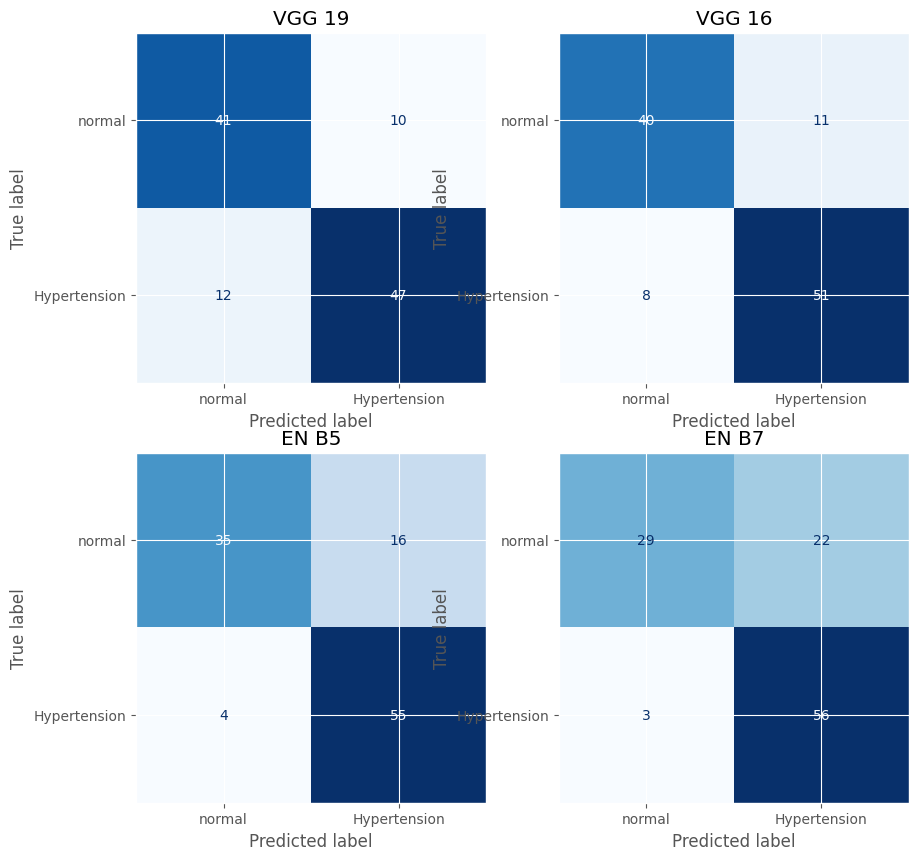

In [ ]:
plot_conf_matrix(h_y_test, h_vgg_19_y_pred, h_vgg_16_y_pred, h_en_b5_y_pred, h_en_b7_y_pred, "Hypertension")

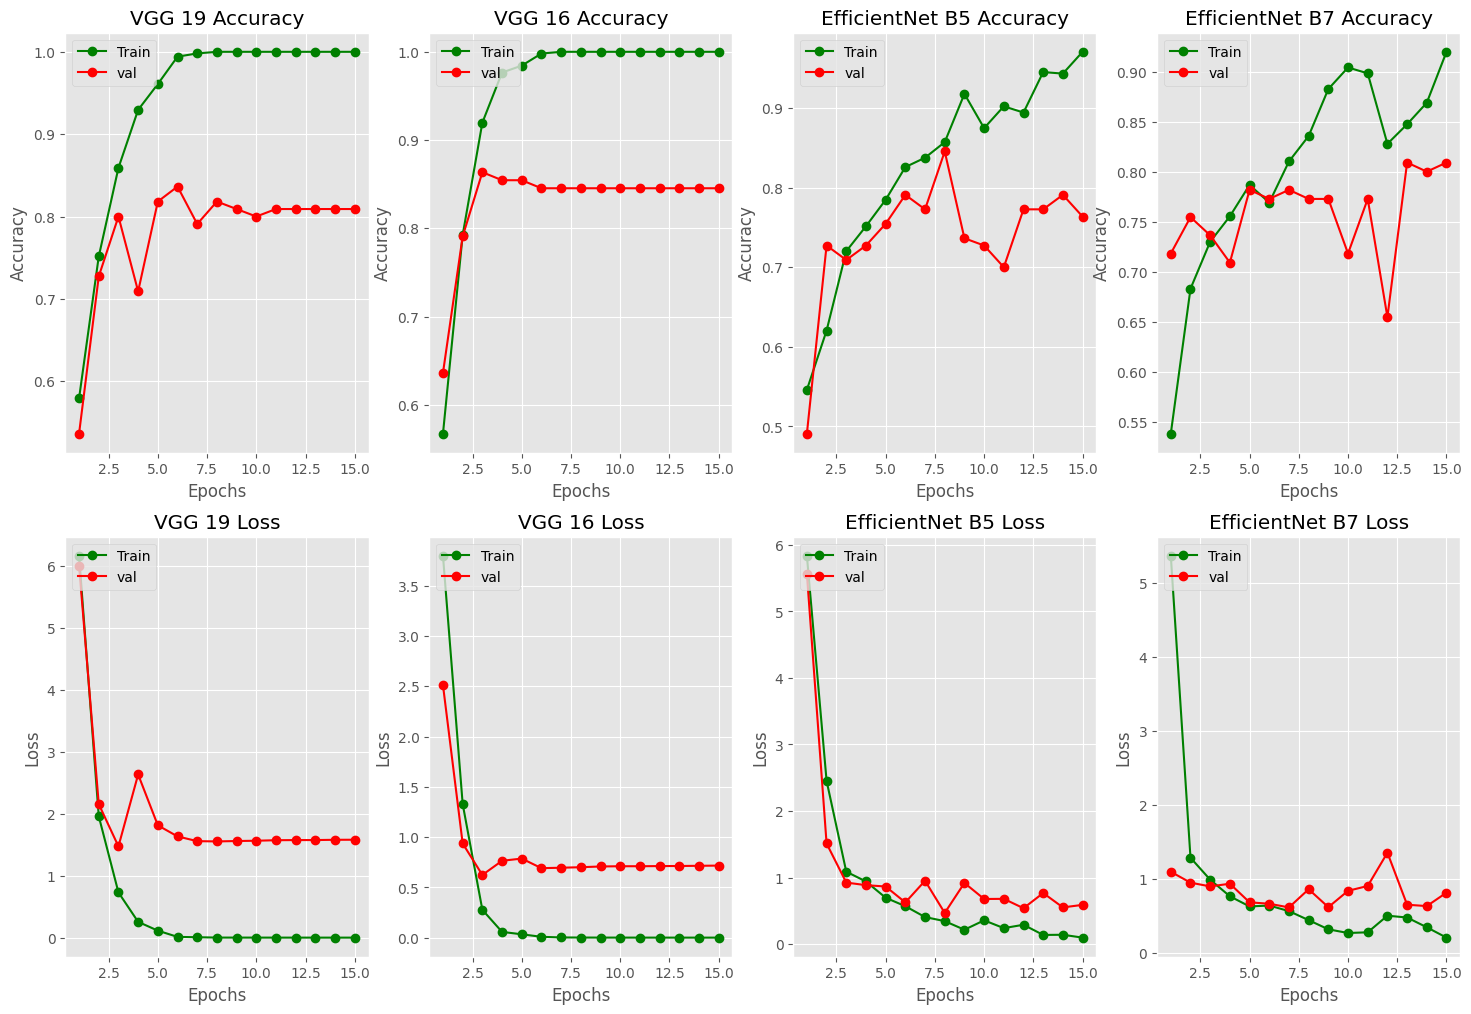

In [ ]:
plot_accuracy_and_loss(h_vgg_19_history, h_vgg_16_history, h_en_b5_history, h_en_b7_history)

### Myopia

In [ ]:
m_x_train,m_x_test,m_x_val, m_y_val,m_y_train,m_y_test=get_train_val_test_data(m_dataset, 0.7)

In [ ]:
m_vgg_19=init_vgg_19_model()
m_vgg_16=init_vgg_16_model()
m_en_b5=init_en_b5_model()
m_en_b7=init_en_b7_model()

In [ ]:
m_vgg_19_model = init_model(m_vgg_19)
m_vgg_16_model = init_model(m_vgg_16)
m_en_b5_model = init_model(m_en_b5)
m_en_b7_model = init_model(m_en_b7)

In [ ]:
m_vgg_19_callbacks=get_callbacks("m_vgg19")
m_vgg_16_callbacks=get_callbacks("m_vgg16")
m_en_b5_callbacks=get_callbacks("m_efficient_net_b5")
m_en_b7_callbacks=get_callbacks("m_efficient_net_b7")

In [ ]:
m_vgg_19_history=train_model(m_vgg_19_model, m_x_train, m_y_train, m_x_val, m_y_val, m_vgg_19_callbacks)

Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 0.9584 - accuracy: 0.8800

21/21 [==============================] - 9s 374ms/step - loss: 0.9584 - accuracy: 0.8800 - val_loss: 0.2940 - val_accuracy: 0.9786
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.2362 - accuracy: 0.9723

21/21 [==============================] - 4s 198ms/step - loss: 0.2362 - accuracy: 0.9723 - val_loss: 0.3382 - val_accuracy: 0.9571
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.0253 - accuracy: 0.9954

21/21 [==============================] - 4s 199ms/step - loss: 0.0253 - accuracy: 0.9954 - val_loss: 0.2143 - val_accuracy: 0.9857
Epoch 4/15
21/21 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

21/21 [==============================] - 5s 229ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2294 - val_accuracy: 0.9857
Epoch 5/15
21/21 [==============================] - ETA: 0s - loss: 1.2440e-04 - accuracy: 1.0000

21/21 [==============================] - 5s 228ms/step - loss: 1.2440e-04 - accuracy: 1.0000 - val_loss: 0.2398 - val_accuracy: 0.9857
Epoch 6/15
21/21 [==============================] - ETA: 0s - loss: 7.3072e-05 - accuracy: 1.0000

21/21 [==============================] - 5s 227ms/step - loss: 7.3072e-05 - accuracy: 1.0000 - val_loss: 0.2374 - val_accuracy: 0.9857
Epoch 7/15
21/21 [==============================] - ETA: 0s - loss: 3.7888e-05 - accuracy: 1.0000

21/21 [==============================] - 4s 197ms/step - loss: 3.7888e-05 - accuracy: 1.0000 - val_loss: 0.2359 - val_accuracy: 0.9857
Epoch 8/15
21/21 [==============================] - ETA: 0s - loss: 2.6021e-05 - accuracy: 1.0000

21/21 [==============================] - 4s 195ms/step - loss: 2.6021e-05 - accuracy: 1.0000 - val_loss: 0.2347 - val_accuracy: 0.9857
Epoch 9/15
21/21 [==============================] - ETA: 0s - loss: 2.1244e-05 - accuracy: 1.0000

21/21 [==============================] - 5s 222ms/step - loss: 2.1244e-05 - accuracy: 1.0000 - val_loss: 0.2338 - val_accuracy: 0.9857
Epoch 10/15
21/21 [==============================] - ETA: 0s - loss: 1.7826e-05 - accuracy: 1.0000

21/21 [==============================] - 5s 221ms/step - loss: 1.7826e-05 - accuracy: 1.0000 - val_loss: 0.2328 - val_accuracy: 0.9857
Epoch 11/15
21/21 [==============================] - ETA: 0s - loss: 1.4993e-05 - accuracy: 1.0000

21/21 [==============================] - 5s 218ms/step - loss: 1.4993e-05 - accuracy: 1.0000 - val_loss: 0.2319 - val_accuracy: 0.9857
Epoch 12/15
21/21 [==============================] - ETA: 0s - loss: 1.3403e-05 - accuracy: 1.0000

21/21 [==============================] - 4s 216ms/step - loss: 1.3403e-05 - accuracy: 1.0000 - val_loss: 0.2314 - val_accuracy: 0.9857
Epoch 13/15
21/21 [==============================] - ETA: 0s - loss: 1.2160e-05 - accuracy: 1.0000

21/21 [==============================] - 5s 219ms/step - loss: 1.2160e-05 - accuracy: 1.0000 - val_loss: 0.2310 - val_accuracy: 0.9857
Epoch 14/15
21/21 [==============================] - ETA: 0s - loss: 1.1220e-05 - accuracy: 1.0000

21/21 [==============================] - 4s 187ms/step - loss: 1.1220e-05 - accuracy: 1.0000 - val_loss: 0.2304 - val_accuracy: 0.9857
Epoch 15/15
21/21 [==============================] - ETA: 0s - loss: 1.0362e-05 - accuracy: 1.0000

21/21 [==============================] - 4s 186ms/step - loss: 1.0362e-05 - accuracy: 1.0000 - val_loss: 0.2299 - val_accuracy: 0.9857


In [ ]:
m_vgg_16_history=train_model(m_vgg_16_model, m_x_train, m_y_train, m_x_val, m_y_val, m_vgg_16_callbacks)

Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 0.9387 - accuracy: 0.8569

21/21 [==============================] - 4s 175ms/step - loss: 0.9387 - accuracy: 0.8569 - val_loss: 0.2680 - val_accuracy: 0.9571
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.9723

21/21 [==============================] - 3s 158ms/step - loss: 0.1590 - accuracy: 0.9723 - val_loss: 0.1645 - val_accuracy: 0.9643
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9969

21/21 [==============================] - 3s 154ms/step - loss: 0.0120 - accuracy: 0.9969 - val_loss: 0.0890 - val_accuracy: 0.9857
Epoch 4/15
21/21 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9985

21/21 [==============================] - 3s 158ms/step - loss: 0.0015 - accuracy: 0.9985 - val_loss: 0.0843 - val_accuracy: 0.9786
Epoch 5/15
21/21 [==============================] - ETA: 0s - loss: 4.1801e-05 - accuracy: 1.0000

21/21 [==============================] - 3s 160ms/step - loss: 4.1801e-05 - accuracy: 1.0000 - val_loss: 0.0875 - val_accuracy: 0.9786
Epoch 6/15
21/21 [==============================] - ETA: 0s - loss: 1.4962e-05 - accuracy: 1.0000

21/21 [==============================] - 3s 162ms/step - loss: 1.4962e-05 - accuracy: 1.0000 - val_loss: 0.0868 - val_accuracy: 0.9786
Epoch 7/15
21/21 [==============================] - ETA: 0s - loss: 1.2376e-05 - accuracy: 1.0000

21/21 [==============================] - 3s 158ms/step - loss: 1.2376e-05 - accuracy: 1.0000 - val_loss: 0.0862 - val_accuracy: 0.9786
Epoch 8/15
21/21 [==============================] - ETA: 0s - loss: 1.0546e-05 - accuracy: 1.0000

21/21 [==============================] - 3s 158ms/step - loss: 1.0546e-05 - accuracy: 1.0000 - val_loss: 0.0859 - val_accuracy: 0.9786
Epoch 9/15
21/21 [==============================] - ETA: 0s - loss: 9.5239e-06 - accuracy: 1.0000

21/21 [==============================] - 3s 162ms/step - loss: 9.5239e-06 - accuracy: 1.0000 - val_loss: 0.0854 - val_accuracy: 0.9786
Epoch 10/15
21/21 [==============================] - ETA: 0s - loss: 8.2286e-06 - accuracy: 1.0000

21/21 [==============================] - 3s 163ms/step - loss: 8.2286e-06 - accuracy: 1.0000 - val_loss: 0.0851 - val_accuracy: 0.9786
Epoch 11/15
21/21 [==============================] - ETA: 0s - loss: 7.5014e-06 - accuracy: 1.0000

21/21 [==============================] - 3s 161ms/step - loss: 7.5014e-06 - accuracy: 1.0000 - val_loss: 0.0848 - val_accuracy: 0.9786
Epoch 12/15
21/21 [==============================] - ETA: 0s - loss: 6.7718e-06 - accuracy: 1.0000

21/21 [==============================] - 3s 159ms/step - loss: 6.7718e-06 - accuracy: 1.0000 - val_loss: 0.0846 - val_accuracy: 0.9786
Epoch 13/15
21/21 [==============================] - ETA: 0s - loss: 6.3119e-06 - accuracy: 1.0000

21/21 [==============================] - 3s 162ms/step - loss: 6.3119e-06 - accuracy: 1.0000 - val_loss: 0.0843 - val_accuracy: 0.9786
Epoch 14/15
21/21 [==============================] - ETA: 0s - loss: 5.7614e-06 - accuracy: 1.0000

21/21 [==============================] - 3s 161ms/step - loss: 5.7614e-06 - accuracy: 1.0000 - val_loss: 0.0841 - val_accuracy: 0.9786
Epoch 15/15
21/21 [==============================] - ETA: 0s - loss: 5.4248e-06 - accuracy: 1.0000

21/21 [==============================] - 3s 161ms/step - loss: 5.4248e-06 - accuracy: 1.0000 - val_loss: 0.0839 - val_accuracy: 0.9786


In [ ]:
m_en_b5_history=train_model(m_en_b5_model, m_x_train, m_y_train, m_x_val, m_y_val, m_en_b5_callbacks)

Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 2.1509 - accuracy: 0.7600

21/21 [==============================] - 27s 553ms/step - loss: 2.1509 - accuracy: 0.7600 - val_loss: 1.0449 - val_accuracy: 0.9000
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.3354 - accuracy: 0.9508

21/21 [==============================] - 6s 266ms/step - loss: 0.3354 - accuracy: 0.9508 - val_loss: 0.2169 - val_accuracy: 0.9500
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9708

21/21 [==============================] - 5s 256ms/step - loss: 0.1525 - accuracy: 0.9708 - val_loss: 0.2338 - val_accuracy: 0.9786
Epoch 4/15
21/21 [==============================] - ETA: 0s - loss: 0.0625 - accuracy: 0.9862

21/21 [==============================] - 5s 250ms/step - loss: 0.0625 - accuracy: 0.9862 - val_loss: 0.2035 - val_accuracy: 0.9571
Epoch 5/15
21/21 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9938

21/21 [==============================] - 6s 270ms/step - loss: 0.0249 - accuracy: 0.9938 - val_loss: 0.2688 - val_accuracy: 0.9714
Epoch 6/15
21/21 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 0.9954

21/21 [==============================] - 6s 275ms/step - loss: 0.0203 - accuracy: 0.9954 - val_loss: 0.2005 - val_accuracy: 0.9786
Epoch 7/15
21/21 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9846

21/21 [==============================] - 6s 271ms/step - loss: 0.0466 - accuracy: 0.9846 - val_loss: 0.2297 - val_accuracy: 0.9429
Epoch 8/15
21/21 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9954

21/21 [==============================] - 6s 276ms/step - loss: 0.0162 - accuracy: 0.9954 - val_loss: 0.1337 - val_accuracy: 0.9857
Epoch 9/15
21/21 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9969

21/21 [==============================] - 6s 268ms/step - loss: 0.0052 - accuracy: 0.9969 - val_loss: 0.1222 - val_accuracy: 0.9857
Epoch 10/15
21/21 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9969

21/21 [==============================] - 5s 252ms/step - loss: 0.0062 - accuracy: 0.9969 - val_loss: 0.1250 - val_accuracy: 0.9857
Epoch 11/15
21/21 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9969

21/21 [==============================] - 5s 253ms/step - loss: 0.0047 - accuracy: 0.9969 - val_loss: 0.2075 - val_accuracy: 0.9714
Epoch 12/15
21/21 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9969

21/21 [==============================] - 5s 247ms/step - loss: 0.0066 - accuracy: 0.9969 - val_loss: 0.2348 - val_accuracy: 0.9714
Epoch 13/15
21/21 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

21/21 [==============================] - 6s 272ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1563 - val_accuracy: 0.9857
Epoch 14/15
21/21 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9969

21/21 [==============================] - 5s 246ms/step - loss: 0.0040 - accuracy: 0.9969 - val_loss: 0.1672 - val_accuracy: 0.9714
Epoch 15/15
21/21 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9985

21/21 [==============================] - 6s 266ms/step - loss: 0.0096 - accuracy: 0.9985 - val_loss: 0.1511 - val_accuracy: 0.9857


In [ ]:
m_en_b7_history=train_model(m_en_b7_model, m_x_train, m_y_train, m_x_val, m_y_val, m_en_b7_callbacks)

Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.2579 - accuracy: 0.8015

21/21 [==============================] - 38s 744ms/step - loss: 1.2579 - accuracy: 0.8015 - val_loss: 0.4601 - val_accuracy: 0.9571
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.9569

21/21 [==============================] - 9s 439ms/step - loss: 0.2870 - accuracy: 0.9569 - val_loss: 0.2934 - val_accuracy: 0.9786
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.9831

21/21 [==============================] - 10s 498ms/step - loss: 0.1045 - accuracy: 0.9831 - val_loss: 0.2614 - val_accuracy: 0.9714
Epoch 4/15
21/21 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9846

21/21 [==============================] - 9s 445ms/step - loss: 0.0915 - accuracy: 0.9846 - val_loss: 0.2673 - val_accuracy: 0.9786
Epoch 5/15
21/21 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9785

21/21 [==============================] - 10s 483ms/step - loss: 0.0559 - accuracy: 0.9785 - val_loss: 0.2901 - val_accuracy: 0.9786
Epoch 6/15
21/21 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9862

21/21 [==============================] - 10s 483ms/step - loss: 0.0434 - accuracy: 0.9862 - val_loss: 0.2176 - val_accuracy: 0.9857
Epoch 7/15
21/21 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9908

21/21 [==============================] - 10s 483ms/step - loss: 0.0120 - accuracy: 0.9908 - val_loss: 0.1915 - val_accuracy: 0.9857
Epoch 8/15
21/21 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9938

21/21 [==============================] - 10s 481ms/step - loss: 0.0143 - accuracy: 0.9938 - val_loss: 0.2211 - val_accuracy: 0.9929
Epoch 9/15
21/21 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9892

21/21 [==============================] - 9s 432ms/step - loss: 0.0354 - accuracy: 0.9892 - val_loss: 0.2457 - val_accuracy: 0.9929
Epoch 10/15
21/21 [==============================] - ETA: 0s - loss: 0.0253 - accuracy: 0.9938

21/21 [==============================] - 10s 487ms/step - loss: 0.0253 - accuracy: 0.9938 - val_loss: 0.2274 - val_accuracy: 0.9929
Epoch 11/15
21/21 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9969

21/21 [==============================] - 10s 488ms/step - loss: 0.0074 - accuracy: 0.9969 - val_loss: 0.1893 - val_accuracy: 0.9929
Epoch 12/15
21/21 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9892

21/21 [==============================] - 10s 484ms/step - loss: 0.0334 - accuracy: 0.9892 - val_loss: 0.2805 - val_accuracy: 0.9714
Epoch 13/15
21/21 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9923

21/21 [==============================] - 10s 487ms/step - loss: 0.0168 - accuracy: 0.9923 - val_loss: 0.1929 - val_accuracy: 0.9929
Epoch 14/15
21/21 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9969

21/21 [==============================] - 9s 438ms/step - loss: 0.0099 - accuracy: 0.9969 - val_loss: 0.2004 - val_accuracy: 0.9929
Epoch 15/15
21/21 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9938

21/21 [==============================] - 10s 484ms/step - loss: 0.0115 - accuracy: 0.9938 - val_loss: 0.2082 - val_accuracy: 0.9786


In [ ]:
m_vgg_19_loss, m_vgg_19_accuracy = get_loss_and_accuracy(m_vgg_19_model, m_x_val, m_y_val)
m_vgg_16_loss, m_vgg_16_accuracy = get_loss_and_accuracy(m_vgg_16_model, m_x_val, m_y_val)
m_en_b5_loss, m_en_b5_accuracy = get_loss_and_accuracy(m_en_b5_model, m_x_val, m_y_val)
m_en_b7_loss, m_en_b7_accuracy = get_loss_and_accuracy(m_en_b7_model, m_x_val, m_y_val)
print("Myopia Losses:")
print("VGG_19: " ,m_vgg_19_loss)
print("VGG_16: " ,m_vgg_16_loss)
print("EfficientNet B5: " ,m_en_b5_loss)
print("EfficientNet B7: " ,m_en_b7_loss)

print("\Myopia Accuracy:")
print("VGG_19: " ,m_vgg_19_accuracy)
print("VGG_16: " ,m_vgg_16_accuracy)
print("EfficientNet_B5: " ,m_en_b5_accuracy)
print("EfficientNet_B7: " ,m_en_b7_accuracy)

5/5 [==============================] - 2s 305ms/step - loss: 0.2082 - accuracy: 0.9786
Myopia Losses:
VGG_19:  0.2298717200756073
VGG_16:  0.08386298269033432
EfficientNet B5:  0.151091068983078
EfficientNet B7:  0.20818141102790833
\Myopia Accuracy:
VGG_19:  0.9857142567634583
VGG_16:  0.9785714149475098
EfficientNet_B5:  0.9857142567634583
EfficientNet_B7:  0.9785714149475098


In [ ]:
m_vgg_19_y_pred = predict(m_vgg_19_model, m_x_test)
m_vgg_16_y_pred = predict(m_vgg_16_model, m_x_test)
m_en_b5_y_pred = predict(m_en_b5_model, m_x_test)
m_en_b7_y_pred = predict(m_en_b7_model, m_x_test)

5/5 [==============================] - 7s 596ms/step


In [ ]:
save_model(m_vgg_19_model, "m_vgg_19_model")
save_model(m_vgg_16_model, "m_vgg_16_model")
save_model(m_en_b5_model, "m_en_b5_model")
save_model(m_en_b7_model, "m_en_b7_model")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print("Myopia Accuracy:")
print("VGG_19: ", get_accuracy_score(m_y_test,m_vgg_19_y_pred))
print("VGG_16: ", get_accuracy_score(m_y_test,m_vgg_16_y_pred))
print("EN_B5: ", get_accuracy_score(m_y_test,m_en_b5_y_pred))
print("EN_B7: ", get_accuracy_score(m_y_test,m_en_b7_y_pred))

Myopia Accuracy:
VGG_19:  0.9928057553956835
VGG_16:  0.9856115107913669
EN_B5:  0.9928057553956835
EN_B7:  0.9856115107913669


In [ ]:
print(get_classification_report(m_y_test,m_vgg_19_y_pred))
print(get_classification_report(m_y_test,m_vgg_16_y_pred))
print(get_classification_report(m_y_test,m_en_b5_y_pred))
print(get_classification_report(m_y_test,m_en_b7_y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        64
           1       1.00      0.99      0.99        75

    accuracy                           0.99       139
   macro avg       0.99      0.99      0.99       139
weighted avg       0.99      0.99      0.99       139

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        64
           1       0.99      0.99      0.99        75

    accuracy                           0.99       139
   macro avg       0.99      0.99      0.99       139
weighted avg       0.99      0.99      0.99       139

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        64
           1       1.00      0.99      0.99        75

    accuracy                           0.99       139
   macro avg       0.99      0.99      0.99       139
weighted avg       0.99      0.99      0.99       139

              preci

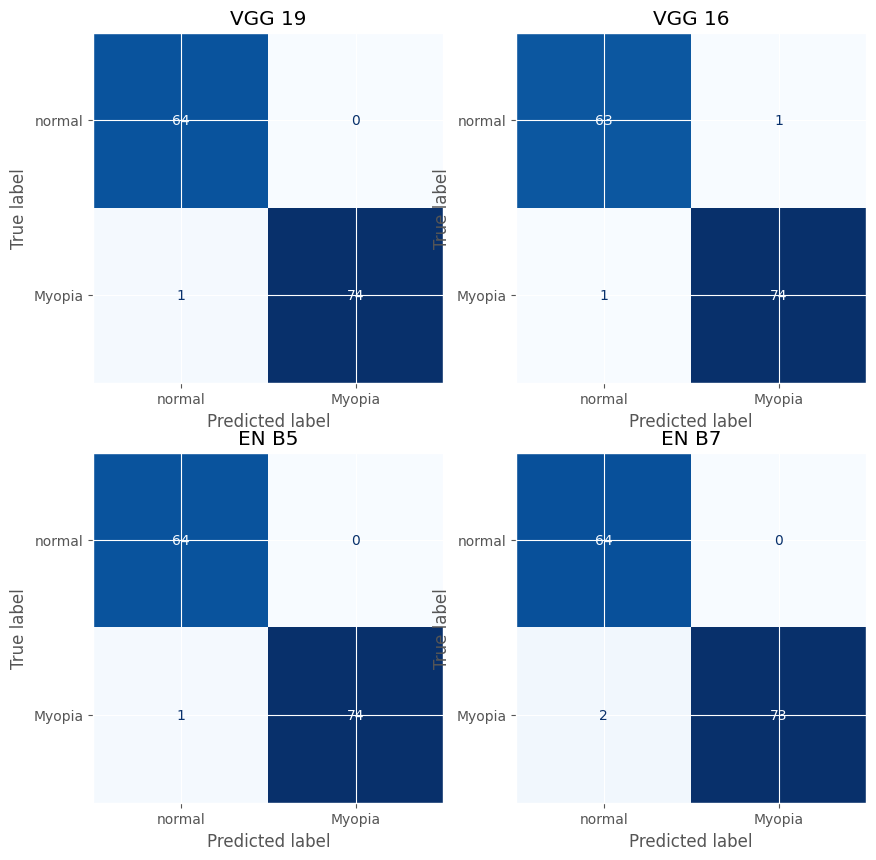

In [ ]:
plot_conf_matrix(m_y_test, m_vgg_19_y_pred, m_vgg_16_y_pred, m_en_b5_y_pred, m_en_b7_y_pred, "Myopia")

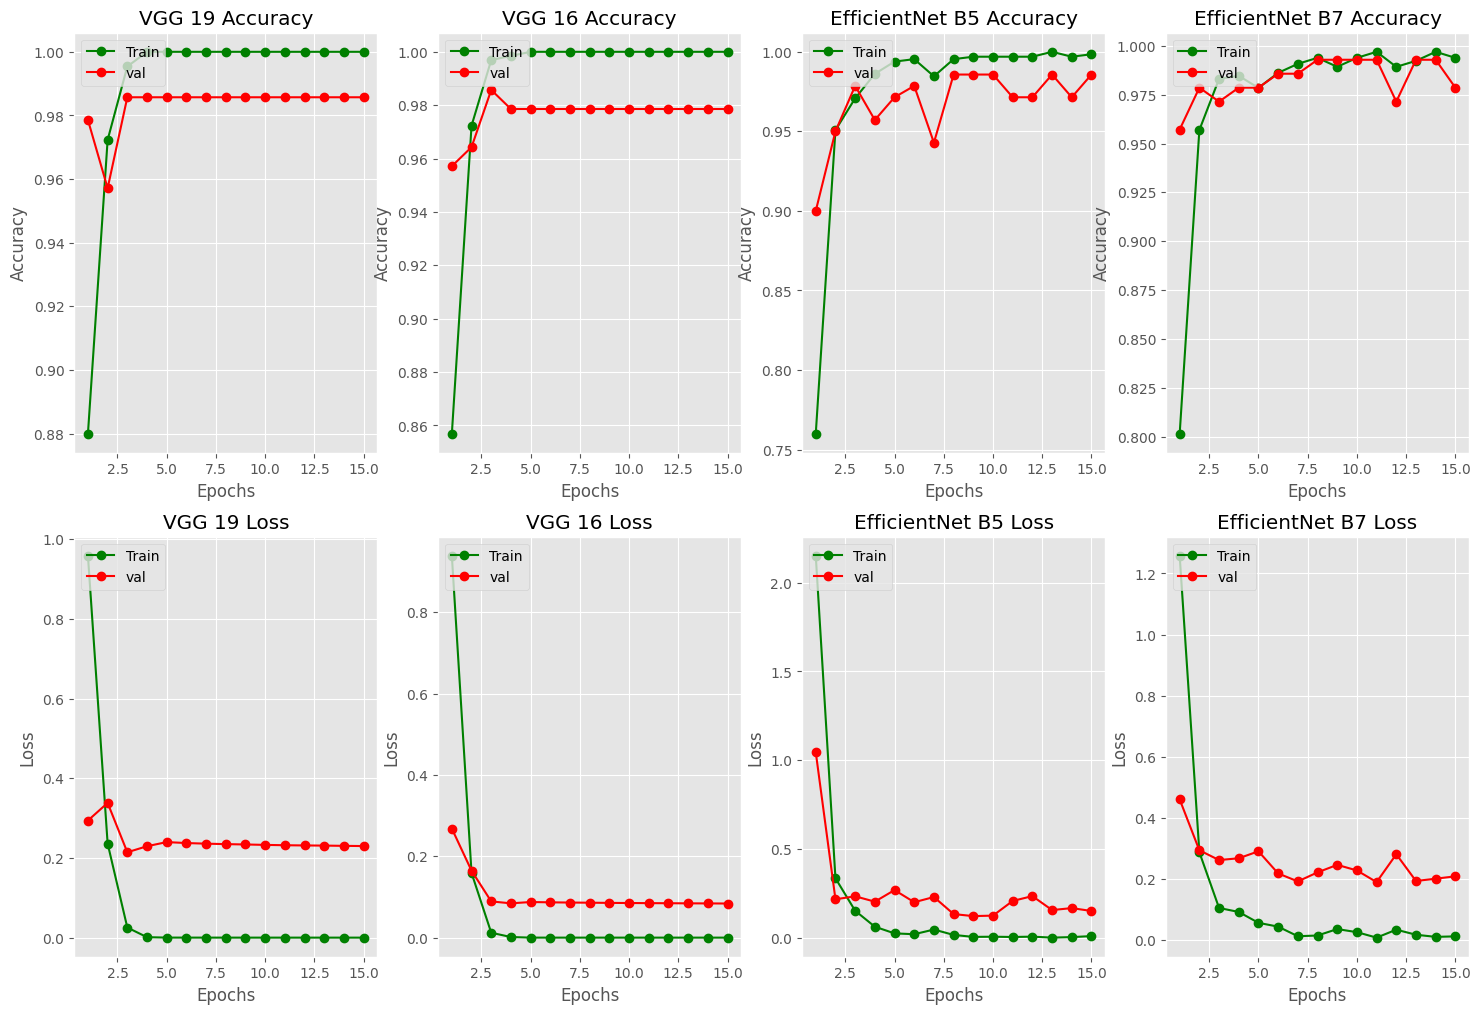

In [ ]:
plot_accuracy_and_loss(m_vgg_19_history, m_vgg_16_history, m_en_b5_history, m_en_b7_history)

### Diabetics

In [ ]:
d_x_train,d_x_test,d_x_val, d_y_val,d_y_train,d_y_test=get_train_val_test_data(d_dataset, 0.7)

In [ ]:
d_vgg_19=init_vgg_19_model()
d_vgg_16=init_vgg_16_model()
d_en_b5=init_en_b5_model()
d_en_b7=init_en_b7_model()

In [ ]:
d_vgg_19_model = init_model(d_vgg_19)
d_vgg_16_model = init_model(d_vgg_16)
d_en_b5_model = init_model(d_en_b5)
d_en_b7_model = init_model(d_en_b7)

In [ ]:
d_vgg_19_callbacks=get_callbacks("d_vgg19")
d_vgg_16_callbacks=get_callbacks("d_vgg16")
d_en_b5_callbacks=get_callbacks("d_efficient_net_b5")
d_en_b7_callbacks=get_callbacks("d_efficient_net_b7")

In [ ]:
d_vgg_19_history=train_model(d_vgg_19_model, d_x_train, d_y_train, d_x_val, d_y_val, d_vgg_19_callbacks)

Epoch 1/15
141/141 [==============================] - ETA: 0s - loss: 2.7279 - accuracy: 0.6106

141/141 [==============================] - 41s 198ms/step - loss: 2.7279 - accuracy: 0.6106 - val_loss: 6.0880 - val_accuracy: 0.5435
Epoch 2/15
141/141 [==============================] - ETA: 0s - loss: 1.5217 - accuracy: 0.7428

141/141 [==============================] - 24s 171ms/step - loss: 1.5217 - accuracy: 0.7428 - val_loss: 1.8133 - val_accuracy: 0.7070
Epoch 3/15
141/141 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.8405

141/141 [==============================] - 25s 175ms/step - loss: 0.6569 - accuracy: 0.8405 - val_loss: 1.3308 - val_accuracy: 0.7598
Epoch 4/15
141/141 [==============================] - ETA: 0s - loss: 0.5584 - accuracy: 0.8602

141/141 [==============================] - 26s 183ms/step - loss: 0.5584 - accuracy: 0.8602 - val_loss: 1.6749 - val_accuracy: 0.7526
Epoch 5/15
141/141 [==============================] - ETA: 0s - loss: 0.3202 - accuracy: 0.9137

141/141 [==============================] - 27s 190ms/step - loss: 0.3202 - accuracy: 0.9137 - val_loss: 1.9168 - val_accuracy: 0.7340
Epoch 6/15
141/141 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.9303

141/141 [==============================] - 27s 195ms/step - loss: 0.2296 - accuracy: 0.9303 - val_loss: 1.2427 - val_accuracy: 0.8126
Epoch 7/15
141/141 [==============================] - ETA: 0s - loss: 0.1664 - accuracy: 0.9472

141/141 [==============================] - 28s 198ms/step - loss: 0.1664 - accuracy: 0.9472 - val_loss: 1.1414 - val_accuracy: 0.8168
Epoch 8/15
141/141 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9576

141/141 [==============================] - 28s 196ms/step - loss: 0.1344 - accuracy: 0.9576 - val_loss: 1.3349 - val_accuracy: 0.8075
Epoch 9/15
141/141 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9842

141/141 [==============================] - 28s 198ms/step - loss: 0.0505 - accuracy: 0.9842 - val_loss: 1.4054 - val_accuracy: 0.8147
Epoch 10/15
141/141 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9909

141/141 [==============================] - 28s 197ms/step - loss: 0.0256 - accuracy: 0.9909 - val_loss: 1.3041 - val_accuracy: 0.8333
Epoch 11/15
141/141 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9751

141/141 [==============================] - 28s 199ms/step - loss: 0.0699 - accuracy: 0.9751 - val_loss: 1.3868 - val_accuracy: 0.8364
Epoch 12/15
141/141 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 0.9774

141/141 [==============================] - 28s 199ms/step - loss: 0.0787 - accuracy: 0.9774 - val_loss: 1.5881 - val_accuracy: 0.8157
Epoch 13/15
141/141 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 0.9636

141/141 [==============================] - 28s 198ms/step - loss: 0.1143 - accuracy: 0.9636 - val_loss: 1.3484 - val_accuracy: 0.8344
Epoch 14/15
141/141 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9605

141/141 [==============================] - 28s 196ms/step - loss: 0.1643 - accuracy: 0.9605 - val_loss: 1.7958 - val_accuracy: 0.8075
Epoch 15/15
141/141 [==============================] - ETA: 0s - loss: 0.5811 - accuracy: 0.8970

141/141 [==============================] - 28s 199ms/step - loss: 0.5811 - accuracy: 0.8970 - val_loss: 2.1391 - val_accuracy: 0.7981


In [ ]:
d_vgg_16_history=train_model(d_vgg_16_model, d_x_train, d_y_train, d_x_val, d_y_val, d_vgg_16_callbacks)

Epoch 1/15
141/141 [==============================] - ETA: 0s - loss: 2.4996 - accuracy: 0.6126

141/141 [==============================] - 25s 172ms/step - loss: 2.4996 - accuracy: 0.6126 - val_loss: 1.5719 - val_accuracy: 0.6843
Epoch 2/15
141/141 [==============================] - ETA: 0s - loss: 0.8615 - accuracy: 0.7768

141/141 [==============================] - 24s 168ms/step - loss: 0.8615 - accuracy: 0.7768 - val_loss: 1.3993 - val_accuracy: 0.7164
Epoch 3/15
141/141 [==============================] - ETA: 0s - loss: 0.4699 - accuracy: 0.8635

141/141 [==============================] - 23s 160ms/step - loss: 0.4699 - accuracy: 0.8635 - val_loss: 0.8459 - val_accuracy: 0.7981
Epoch 4/15
141/141 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.9010

141/141 [==============================] - 24s 168ms/step - loss: 0.3097 - accuracy: 0.9010 - val_loss: 0.9817 - val_accuracy: 0.8033
Epoch 5/15
141/141 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9379

141/141 [==============================] - 24s 168ms/step - loss: 0.1738 - accuracy: 0.9379 - val_loss: 0.8686 - val_accuracy: 0.8354
Epoch 6/15
141/141 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.9692

141/141 [==============================] - 22s 159ms/step - loss: 0.0873 - accuracy: 0.9692 - val_loss: 1.1267 - val_accuracy: 0.7992
Epoch 7/15
141/141 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9714

141/141 [==============================] - 23s 160ms/step - loss: 0.0765 - accuracy: 0.9714 - val_loss: 0.8994 - val_accuracy: 0.8582
Epoch 8/15
141/141 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.9683

141/141 [==============================] - 23s 160ms/step - loss: 0.0819 - accuracy: 0.9683 - val_loss: 1.3070 - val_accuracy: 0.7961
Epoch 9/15
141/141 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9530

141/141 [==============================] - 24s 168ms/step - loss: 0.1388 - accuracy: 0.9530 - val_loss: 1.0474 - val_accuracy: 0.8437
Epoch 10/15
141/141 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.9492

141/141 [==============================] - 24s 167ms/step - loss: 0.1640 - accuracy: 0.9492 - val_loss: 1.0812 - val_accuracy: 0.8551
Epoch 11/15
141/141 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9627

141/141 [==============================] - 24s 167ms/step - loss: 0.1120 - accuracy: 0.9627 - val_loss: 1.1786 - val_accuracy: 0.8551
Epoch 12/15
141/141 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.9297

141/141 [==============================] - 23s 160ms/step - loss: 0.2957 - accuracy: 0.9297 - val_loss: 1.9114 - val_accuracy: 0.7909
Epoch 13/15
141/141 [==============================] - ETA: 0s - loss: 0.3824 - accuracy: 0.9235

141/141 [==============================] - 23s 160ms/step - loss: 0.3824 - accuracy: 0.9235 - val_loss: 1.5072 - val_accuracy: 0.8427
Epoch 14/15
141/141 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9534

141/141 [==============================] - 24s 168ms/step - loss: 0.2070 - accuracy: 0.9534 - val_loss: 1.6304 - val_accuracy: 0.8385
Epoch 15/15
141/141 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9709

141/141 [==============================] - 24s 168ms/step - loss: 0.0981 - accuracy: 0.9709 - val_loss: 1.5139 - val_accuracy: 0.8509


In [ ]:
d_en_b5_history=train_model(d_en_b5_model, d_x_train, d_y_train, d_x_val, d_y_val, d_en_b5_callbacks)

Epoch 1/15
141/141 [==============================] - ETA: 0s - loss: 1.5231 - accuracy: 0.6095

141/141 [==============================] - 60s 301ms/step - loss: 1.5231 - accuracy: 0.6095 - val_loss: 0.6925 - val_accuracy: 0.6936
Epoch 2/15
141/141 [==============================] - ETA: 0s - loss: 1.1589 - accuracy: 0.6543

141/141 [==============================] - 36s 254ms/step - loss: 1.1589 - accuracy: 0.6543 - val_loss: 0.9215 - val_accuracy: 0.6667
Epoch 3/15
141/141 [==============================] - ETA: 0s - loss: 0.7947 - accuracy: 0.6998

141/141 [==============================] - 36s 253ms/step - loss: 0.7947 - accuracy: 0.6998 - val_loss: 0.9087 - val_accuracy: 0.6460
Epoch 4/15
141/141 [==============================] - ETA: 0s - loss: 0.7085 - accuracy: 0.7324

141/141 [==============================] - 40s 284ms/step - loss: 0.7085 - accuracy: 0.7324 - val_loss: 0.8673 - val_accuracy: 0.6915
Epoch 5/15
141/141 [==============================] - ETA: 0s - loss: 0.7486 - accuracy: 0.7326

141/141 [==============================] - 36s 254ms/step - loss: 0.7486 - accuracy: 0.7326 - val_loss: 0.7261 - val_accuracy: 0.7091
Epoch 6/15
141/141 [==============================] - ETA: 0s - loss: 0.7044 - accuracy: 0.7369

141/141 [==============================] - 40s 284ms/step - loss: 0.7044 - accuracy: 0.7369 - val_loss: 0.9351 - val_accuracy: 0.6708
Epoch 7/15
141/141 [==============================] - ETA: 0s - loss: 0.6731 - accuracy: 0.7548

141/141 [==============================] - 40s 284ms/step - loss: 0.6731 - accuracy: 0.7548 - val_loss: 0.5808 - val_accuracy: 0.7588
Epoch 8/15
141/141 [==============================] - ETA: 0s - loss: 0.5712 - accuracy: 0.7868

141/141 [==============================] - 40s 284ms/step - loss: 0.5712 - accuracy: 0.7868 - val_loss: 0.8700 - val_accuracy: 0.7164
Epoch 9/15
141/141 [==============================] - ETA: 0s - loss: 0.8901 - accuracy: 0.7453

141/141 [==============================] - 40s 284ms/step - loss: 0.8901 - accuracy: 0.7453 - val_loss: 0.8167 - val_accuracy: 0.7195
Epoch 10/15
141/141 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.7815

141/141 [==============================] - 36s 254ms/step - loss: 0.6868 - accuracy: 0.7815 - val_loss: 3.2862 - val_accuracy: 0.5590
Epoch 11/15
141/141 [==============================] - ETA: 0s - loss: 0.8372 - accuracy: 0.7730

141/141 [==============================] - 36s 257ms/step - loss: 0.8372 - accuracy: 0.7730 - val_loss: 1.4192 - val_accuracy: 0.6356
Epoch 12/15
141/141 [==============================] - ETA: 0s - loss: 0.6215 - accuracy: 0.7985

141/141 [==============================] - 40s 285ms/step - loss: 0.6215 - accuracy: 0.7985 - val_loss: 0.6903 - val_accuracy: 0.7712
Epoch 13/15
141/141 [==============================] - ETA: 0s - loss: 0.6065 - accuracy: 0.8050

141/141 [==============================] - 40s 285ms/step - loss: 0.6065 - accuracy: 0.8050 - val_loss: 1.2235 - val_accuracy: 0.6894
Epoch 14/15
141/141 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.7961

141/141 [==============================] - 36s 255ms/step - loss: 0.6536 - accuracy: 0.7961 - val_loss: 0.8886 - val_accuracy: 0.7464
Epoch 15/15
141/141 [==============================] - ETA: 0s - loss: 0.5982 - accuracy: 0.8150

141/141 [==============================] - 40s 286ms/step - loss: 0.5982 - accuracy: 0.8150 - val_loss: 1.5715 - val_accuracy: 0.6201


In [ ]:
d_en_b7_history=train_model(d_en_b7_model, d_x_train, d_y_train, d_x_val, d_y_val, d_en_b7_callbacks)

Epoch 1/15
141/141 [==============================] - ETA: 0s - loss: 1.7265 - accuracy: 0.6099

141/141 [==============================] - 102s 559ms/step - loss: 1.7265 - accuracy: 0.6099 - val_loss: 1.1879 - val_accuracy: 0.6315
Epoch 2/15
141/141 [==============================] - ETA: 0s - loss: 1.0509 - accuracy: 0.6530

141/141 [==============================] - 73s 516ms/step - loss: 1.0509 - accuracy: 0.6530 - val_loss: 2.0073 - val_accuracy: 0.6149
Epoch 3/15
141/141 [==============================] - ETA: 0s - loss: 1.0502 - accuracy: 0.6763

141/141 [==============================] - 63s 445ms/step - loss: 1.0502 - accuracy: 0.6763 - val_loss: 1.3027 - val_accuracy: 0.6615
Epoch 4/15
141/141 [==============================] - ETA: 0s - loss: 1.1552 - accuracy: 0.6878

141/141 [==============================] - 72s 512ms/step - loss: 1.1552 - accuracy: 0.6878 - val_loss: 1.3111 - val_accuracy: 0.6366
Epoch 5/15
141/141 [==============================] - ETA: 0s - loss: 0.8564 - accuracy: 0.7162

141/141 [==============================] - 73s 516ms/step - loss: 0.8564 - accuracy: 0.7162 - val_loss: 0.9808 - val_accuracy: 0.6946
Epoch 6/15
141/141 [==============================] - ETA: 0s - loss: 0.8653 - accuracy: 0.7189

141/141 [==============================] - 63s 445ms/step - loss: 0.8653 - accuracy: 0.7189 - val_loss: 0.8374 - val_accuracy: 0.7371
Epoch 7/15
141/141 [==============================] - ETA: 0s - loss: 1.3930 - accuracy: 0.6923

141/141 [==============================] - 72s 510ms/step - loss: 1.3930 - accuracy: 0.6923 - val_loss: 0.8648 - val_accuracy: 0.7101
Epoch 8/15
141/141 [==============================] - ETA: 0s - loss: 0.7865 - accuracy: 0.7499

141/141 [==============================] - 72s 513ms/step - loss: 0.7865 - accuracy: 0.7499 - val_loss: 1.5075 - val_accuracy: 0.6201
Epoch 9/15
141/141 [==============================] - ETA: 0s - loss: 1.0147 - accuracy: 0.7284

141/141 [==============================] - 63s 445ms/step - loss: 1.0147 - accuracy: 0.7284 - val_loss: 1.0160 - val_accuracy: 0.6977
Epoch 10/15
141/141 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.7888

141/141 [==============================] - 62s 440ms/step - loss: 0.6047 - accuracy: 0.7888 - val_loss: 0.9103 - val_accuracy: 0.7091
Epoch 11/15
141/141 [==============================] - ETA: 0s - loss: 0.7446 - accuracy: 0.7692

141/141 [==============================] - 72s 512ms/step - loss: 0.7446 - accuracy: 0.7692 - val_loss: 2.3583 - val_accuracy: 0.5952
Epoch 12/15
141/141 [==============================] - ETA: 0s - loss: 0.9356 - accuracy: 0.7473

141/141 [==============================] - 63s 444ms/step - loss: 0.9356 - accuracy: 0.7473 - val_loss: 0.8350 - val_accuracy: 0.7205
Epoch 13/15
141/141 [==============================] - ETA: 0s - loss: 0.8194 - accuracy: 0.7648

141/141 [==============================] - 62s 440ms/step - loss: 0.8194 - accuracy: 0.7648 - val_loss: 0.7656 - val_accuracy: 0.7547
Epoch 14/15
141/141 [==============================] - ETA: 0s - loss: 0.8844 - accuracy: 0.7699

141/141 [==============================] - 72s 513ms/step - loss: 0.8844 - accuracy: 0.7699 - val_loss: 1.5588 - val_accuracy: 0.6770
Epoch 15/15
141/141 [==============================] - ETA: 0s - loss: 0.6356 - accuracy: 0.7954

141/141 [==============================] - 72s 514ms/step - loss: 0.6356 - accuracy: 0.7954 - val_loss: 0.6698 - val_accuracy: 0.7712


In [ ]:
d_vgg_19_loss, d_vgg_19_accuracy = get_loss_and_accuracy(d_vgg_19_model, d_x_val, d_y_val)
d_vgg_16_loss, d_vgg_16_accuracy = get_loss_and_accuracy(d_vgg_16_model, d_x_val, d_y_val)
d_en_b5_loss, d_en_b5_accuracy = get_loss_and_accuracy(d_en_b5_model, d_x_val, d_y_val)
d_en_b7_loss, d_en_b7_accuracy = get_loss_and_accuracy(d_en_b7_model, d_x_val, d_y_val)
print("Diabetics Losses:")
print("VGG_19: " ,d_vgg_19_loss)
print("VGG_16: " ,d_vgg_16_loss)
print("EfficientNet B5: " ,d_en_b5_loss)
print("EfficientNet B7: " ,d_en_b7_loss)

print("\nDiabetics Accuracy:")
print("VGG_19: " ,d_vgg_19_accuracy)
print("VGG_16: " ,d_vgg_16_accuracy)
print("EfficientNet_B5: " ,d_en_b5_accuracy)
print("EfficientNet_B7: " ,d_en_b7_accuracy)

31/31 [==============================] - 11s 352ms/step - loss: 0.6698 - accuracy: 0.7712
Diabetics Losses:
VGG_19:  2.1391401290893555
VGG_16:  1.5139483213424683
EfficientNet B5:  1.5715242624282837
EfficientNet B7:  0.6698398590087891

Diabetics Accuracy:
VGG_19:  0.7981366515159607
VGG_16:  0.850931704044342
EfficientNet_B5:  0.6200827956199646
EfficientNet_B7:  0.7712215185165405


In [ ]:
d_vgg_19_y_pred = predict(d_vgg_19_model, d_x_test)
d_vgg_16_y_pred = predict(d_vgg_16_model, d_x_test)
d_en_b5_y_pred = predict(d_en_b5_model, d_x_test)
d_en_b7_y_pred = predict(d_en_b7_model, d_x_test)

31/31 [==============================] - 15s 346ms/step


In [ ]:
save_model(d_vgg_19_model, "d_vgg_19_model")
save_model(d_vgg_16_model, "d_vgg_16_model")
save_model(d_en_b5_model, "d_en_b5_model")
save_model(d_en_b7_model, "d_en_b7_model")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print("Diabetics Accuracy:")
print("VGG_19: ", get_accuracy_score(d_y_test,d_vgg_19_y_pred))
print("VGG_16: ", get_accuracy_score(d_y_test,d_vgg_16_y_pred))
print("EN_B5: ", get_accuracy_score(d_y_test,d_en_b5_y_pred))
print("EN_B7: ", get_accuracy_score(d_y_test,d_en_b7_y_pred))

Diabetics Accuracy:
VGG_19:  0.7991718426501035
VGG_16:  0.8457556935817805
EN_B5:  0.6428571428571429
EN_B7:  0.7660455486542443


In [ ]:
print(get_classification_report(d_y_test,d_vgg_19_y_pred))
print(get_classification_report(d_y_test,d_vgg_16_y_pred))
print(get_classification_report(d_y_test,d_en_b5_y_pred))
print(get_classification_report(d_y_test,d_en_b7_y_pred))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       468
           1       0.78      0.86      0.81       498

    accuracy                           0.80       966
   macro avg       0.80      0.80      0.80       966
weighted avg       0.80      0.80      0.80       966

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       468
           1       0.85      0.86      0.85       498

    accuracy                           0.85       966
   macro avg       0.85      0.85      0.85       966
weighted avg       0.85      0.85      0.85       966

              precision    recall  f1-score   support

           0       0.94      0.28      0.43       468
           1       0.59      0.98      0.74       498

    accuracy                           0.64       966
   macro avg       0.76      0.63      0.59       966
weighted avg       0.76      0.64      0.59       966

              preci

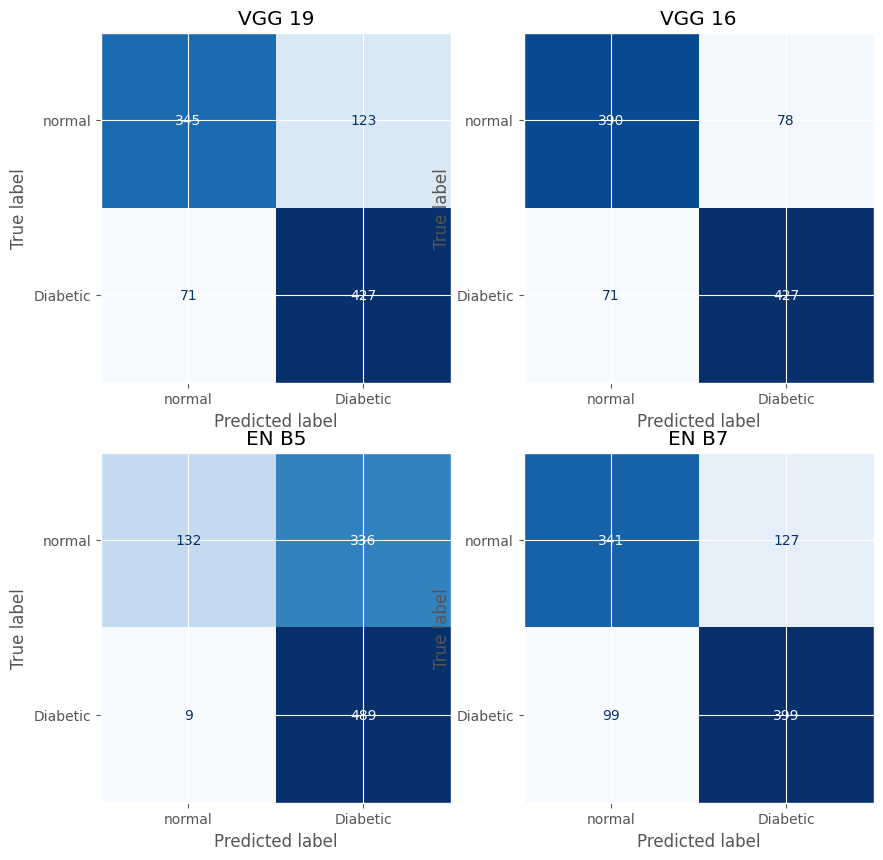

In [ ]:
plot_conf_matrix(d_y_test, d_vgg_19_y_pred, d_vgg_16_y_pred, d_en_b5_y_pred, d_en_b7_y_pred, "Diabetic")

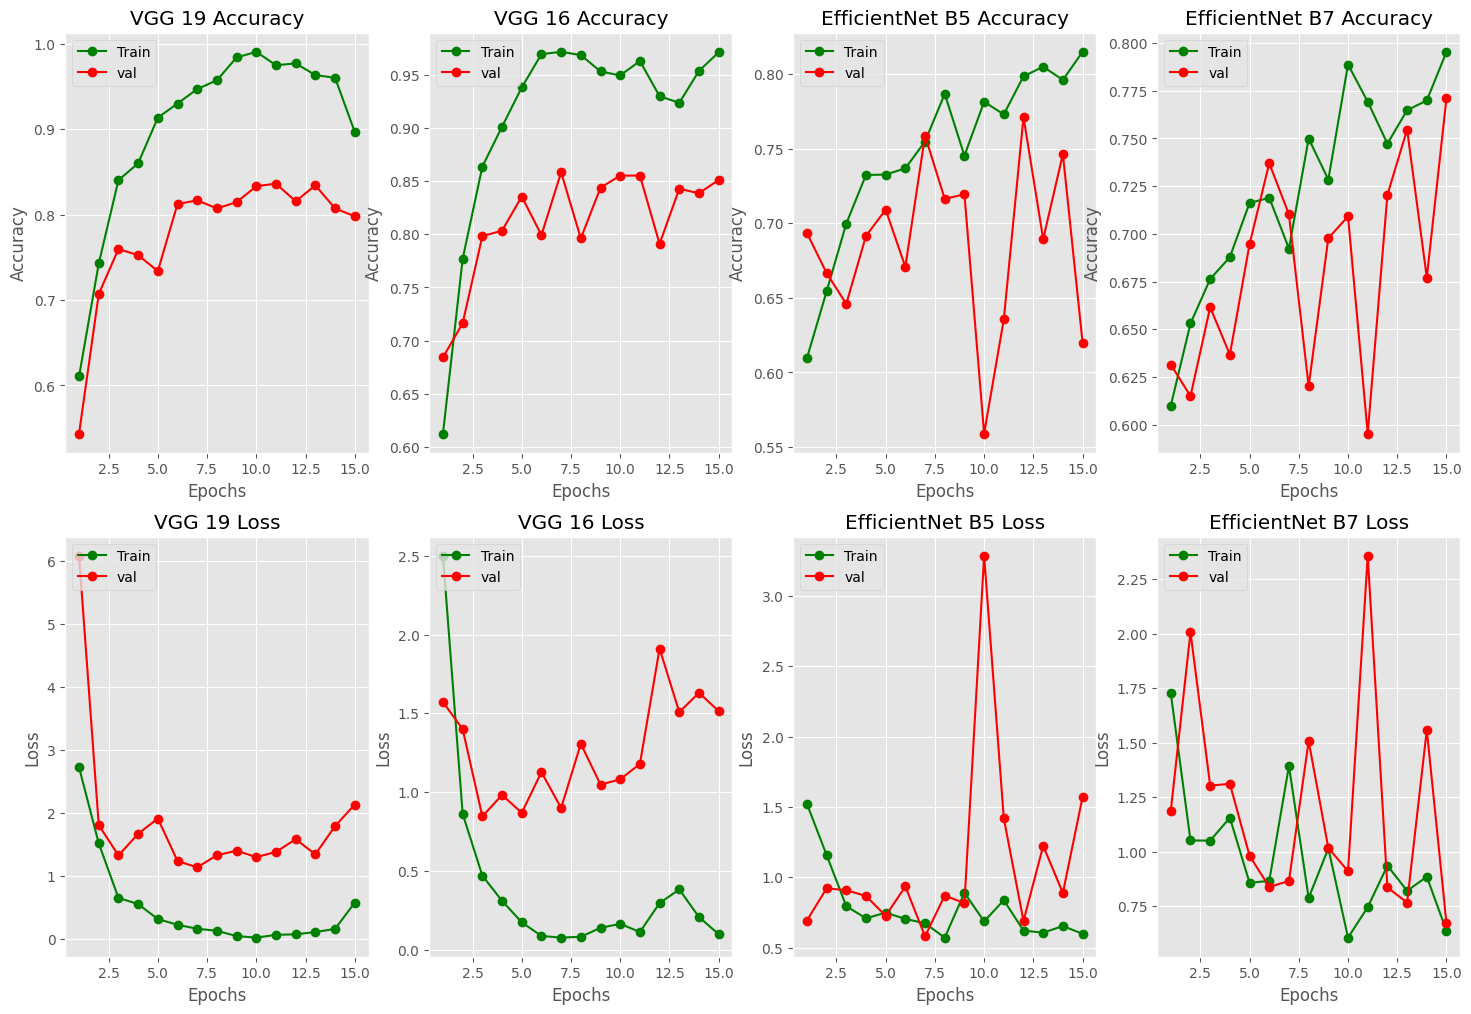

In [ ]:
plot_accuracy_and_loss(d_vgg_19_history, d_vgg_16_history, d_en_b5_history, d_en_b7_history)